In [1]:
import os
import json
import re
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import scipy.stats as stats

In [2]:
def extract_array(s):
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", s)
    return np.array([float(num) for num in numbers])

### Making a dataframe from the results folders to handle the data

In [139]:
# params
path = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
#path = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'

In [140]:
df = pd.read_excel('Positions.xlsx')
df_out = df[df['Quality'] == 'Very good'].copy()
df_out = df_out.reset_index(drop=True)

# Initialize the columns as type 'object' to store arrays/lists
df_out.loc[:,["radius","area","max_av_gr"]] = np.nan
df_out['rad_dyn'] = pd.Series(dtype='object')
df_out['area_dyn'] = pd.Series(dtype='object')
df_out['av_gr_dyn'] = pd.Series(dtype='object')

df_out.loc[:,["gomp_params"]] = np.nan
df_out.loc[:,["t_m"]] = np.nan

# Assign an array to a cell in the DataFrame
# df_out.at[0, 'rad_dyn'] = np.array([0, 1, 2, 3, 4, 5])
# Similarly for 'area_dyn' if needed
# df_out.at[0, 'area_dyn'] = np.array([...])

# Display the head of the DataFrame to check the assignment
df_out.head()

Date   Machine  Position  Strain            DNA Chemical  Pad  \
0 2023-11-15  Ti scope         0  MC4100  pLPT20+pLPT41        -    1   
1 2023-11-15  Ti scope         1  MC4100  pLPT20+pLPT41        -    1   
2 2023-11-15  Ti scope         2  MC4100  pLPT20+pLPT41        -    1   
3 2023-11-15  Ti scope         3  MC4100  pLPT20+pLPT41        -    1   
4 2023-11-15  Ti scope         6  MC4100  pLPT20+pLPT41        -    1   

  Dilution   t_incub      t_im  ...  radj  wedge_adj  radius area  max_av_gr  \
0  10^(-5)  09:25:00  14:41:00  ...  30.0       30.0     NaN  NaN        NaN   
1  10^(-5)  09:25:00  14:41:00  ...  50.0       30.0     NaN  NaN        NaN   
2  10^(-5)  09:25:00  14:41:00  ...  50.0       30.0     NaN  NaN        NaN   
3  10^(-5)  09:25:00  14:41:00  ...  30.0       30.0     NaN  NaN        NaN   
4  10^(-5)  09:25:00  14:41:00  ...  50.0       30.0     NaN  NaN        NaN   

   rad_dyn  area_dyn  av_gr_dyn  gomp_params  t_m  
0      NaN       NaN        NaN          NaN  NaN  
1      NaN       NaN        NaN          NaN  NaN  
2      NaN       NaN        NaN          NaN  NaN  
3      NaN       NaN        NaN          NaN  NaN  
4      NaN       NaN        NaN          NaN  NaN  

[5 rows x 25 columns]

In [159]:
df_out.columns

Index(['Unnamed: 0', 'Date', 'Machine', 'Position', 'Strain', 'DNA',
       'Chemical', 'Pad', 'Dilution', 't_incub', 't_im', 'Quality',
       'exp length', 'Colonies', 'Centers', 'Radius', 'radj', 'wedge_adj',
       'radius', 'area', 'max_av_gr', 'rad_dyn', 'area_dyn', 'av_gr_dyn',
       'gomp_params', 't_m'],
      dtype='object')

#### Extract area and radius endpoints, as well as all dynamics

In [141]:
# extract area and radius from each position's results and store it in a dataframe
scopes = os.listdir(path)
for s in scopes:
    scope_dates = os.listdir(os.path.join(path,s))
    scope_dates.sort()
    for d in scope_dates:
        date = datetime.strptime(d, '%Y_%m_%d')
        data = df_out[(df_out.Date == date) & (df_out.Machine == s)]
        
        pos = data.Position.unique()
        path_results = os.path.join(path,s,d,'results')
        for p in pos:

            path_pos = os.path.join(path_results,f'pos{p}')
            area_path = os.path.join(path_pos, 'area.npy')
            radius_path = os.path.join(path_pos, 'radius.npy')

            ridx = df_out[(df_out.Date == date) & (df_out.Machine==s) & (df_out.Position == p)].index[0]

            # load area and radius
            radius = np.load(radius_path)  

            area = savgol_filter(np.load(area_path), 21, 3)
            area_diff = savgol_filter(np.diff(area), 21, 3)
            av_gr = savgol_filter(area_diff / area[1:], 21, 3)
                        
            # assigning
            df_out.loc[ridx, 'radius'] = radius[-1]
            df_out.loc[ridx, 'area'] = area[-1]
            df_out.loc[ridx, 'max_av_gr'] = np.nanmax(av_gr[np.isfinite(av_gr)])
            
            df_out.at[ridx, 'rad_dyn'] = radius
            df_out.at[ridx, 'area_dyn'] = area
            df_out.at[ridx, 'av_gr_dyn'] = av_gr

In [142]:
df_out.to_excel('out.xlsx')

In [77]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

### Plotting mean radius filtered by date, machine and dilution

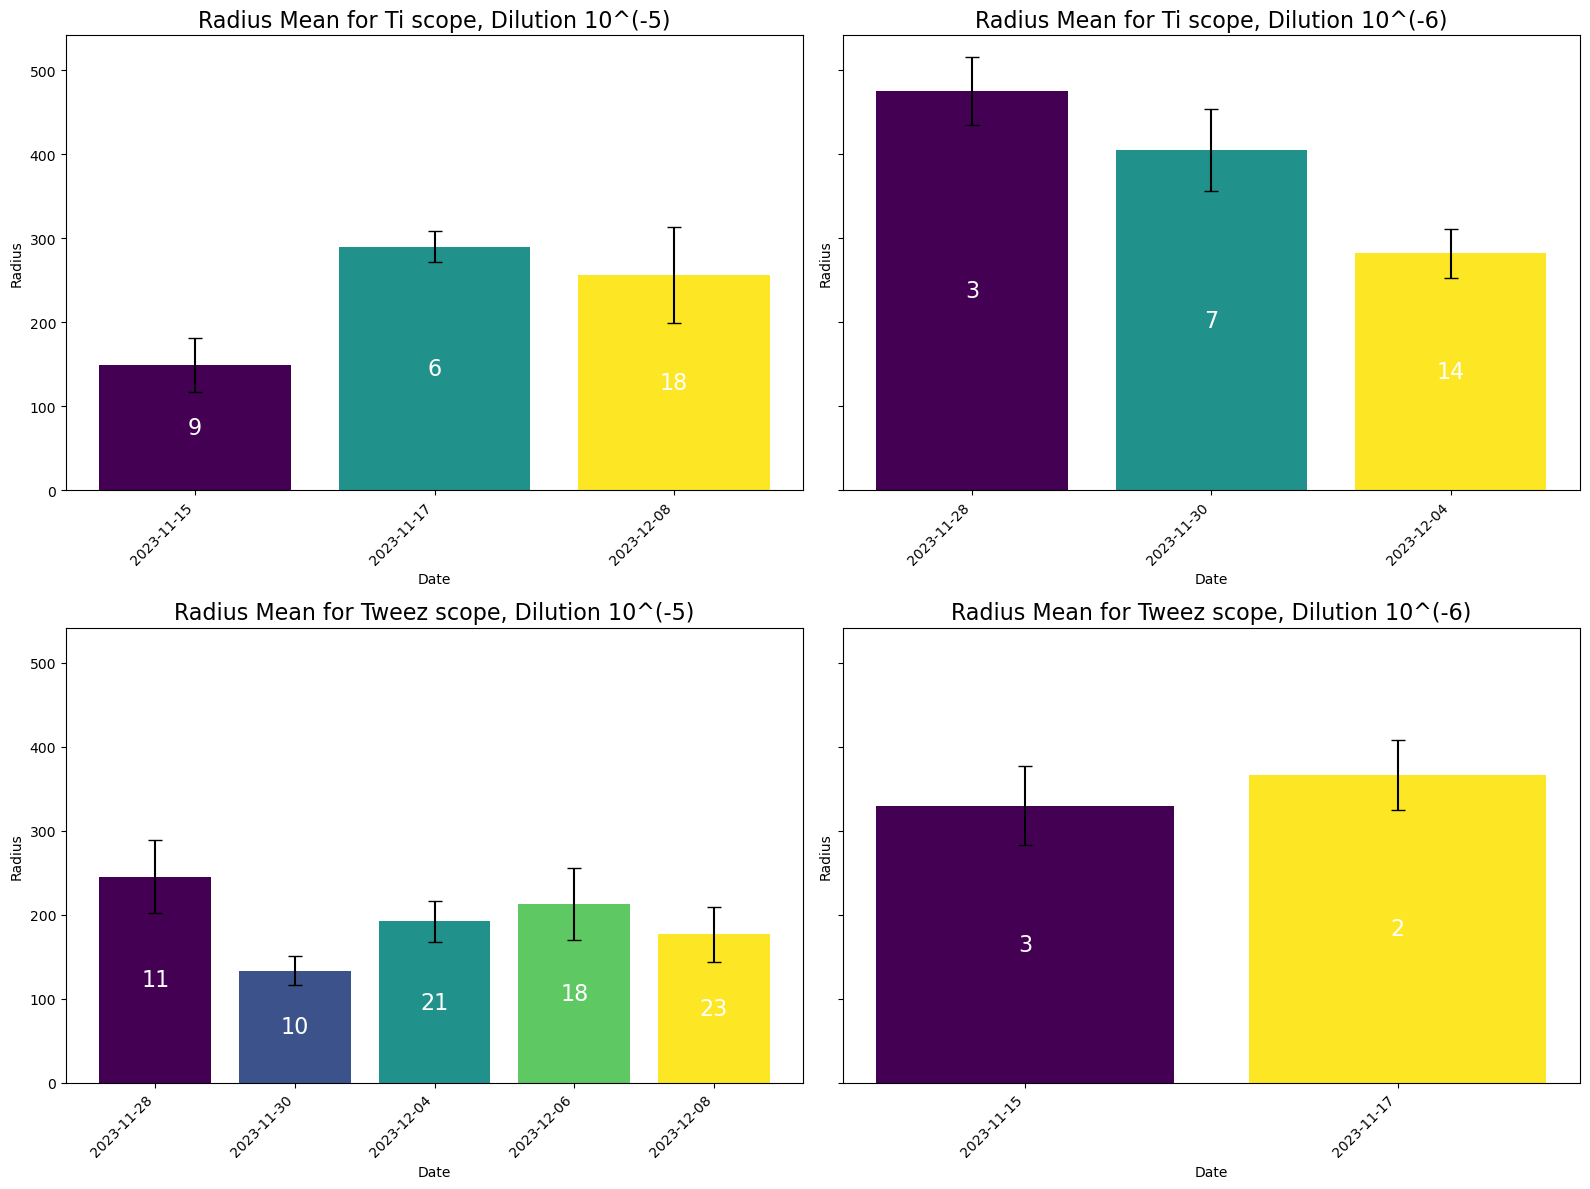

In [95]:
# Group the data by 'Date', 'Machine', 'Dilution', and calculate mean, standard deviation for 'radius' and count colonies
plot_data = df.groupby(['Date', 'Machine', 'Dilution']).agg({
    'radius': ['mean', 'std'],
    'Colonies': 'size'  # This will count the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Date', 'Machine', 'Dilution', 'Radius Mean', 'Radius Std', 'Colonies Count']

# Filter data for each machine and dilution type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
machine_dilutions = plot_data['Machine'].unique()
dilutions = plot_data['Dilution'].unique()

# Use a nested loop to create a subplot for each machine-dilution combination
for i, machine in enumerate(machine_dilutions):
    for j, dilution in enumerate(dilutions):
        sub_data = plot_data[(plot_data['Machine'] == machine) & (plot_data['Dilution'] == dilution)]
        if sub_data.empty:
            axes[i, j].set_xticks([])  # No data for this subplot
            continue
        radius_colors = plt.cm.viridis(np.linspace(0, 1, len(sub_data)))
        index = 0  # Initialize counter for the color array
        for _, row in sub_data.iterrows():
            bar = axes[i, j].bar(index, row['Radius Mean'], yerr=row['Radius Std'], capsize=5, color=radius_colors[index])
            # Annotate the number of colonies inside the bar
            axes[i, j].text(index, row['Radius Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=16)
            index += 1  # Increment counter
        
        axes[i, j].set_title(f'Radius Mean for {machine}, Dilution {dilution}', fontsize=16)
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Radius')
        axes[i, j].set_xticks(range(len(sub_data)))
        axes[i, j].set_xticklabels([f"{row['Date'].date()}" for _, row in sub_data.iterrows()], rotation=45, ha="right")

plt.tight_layout()
plt.show()


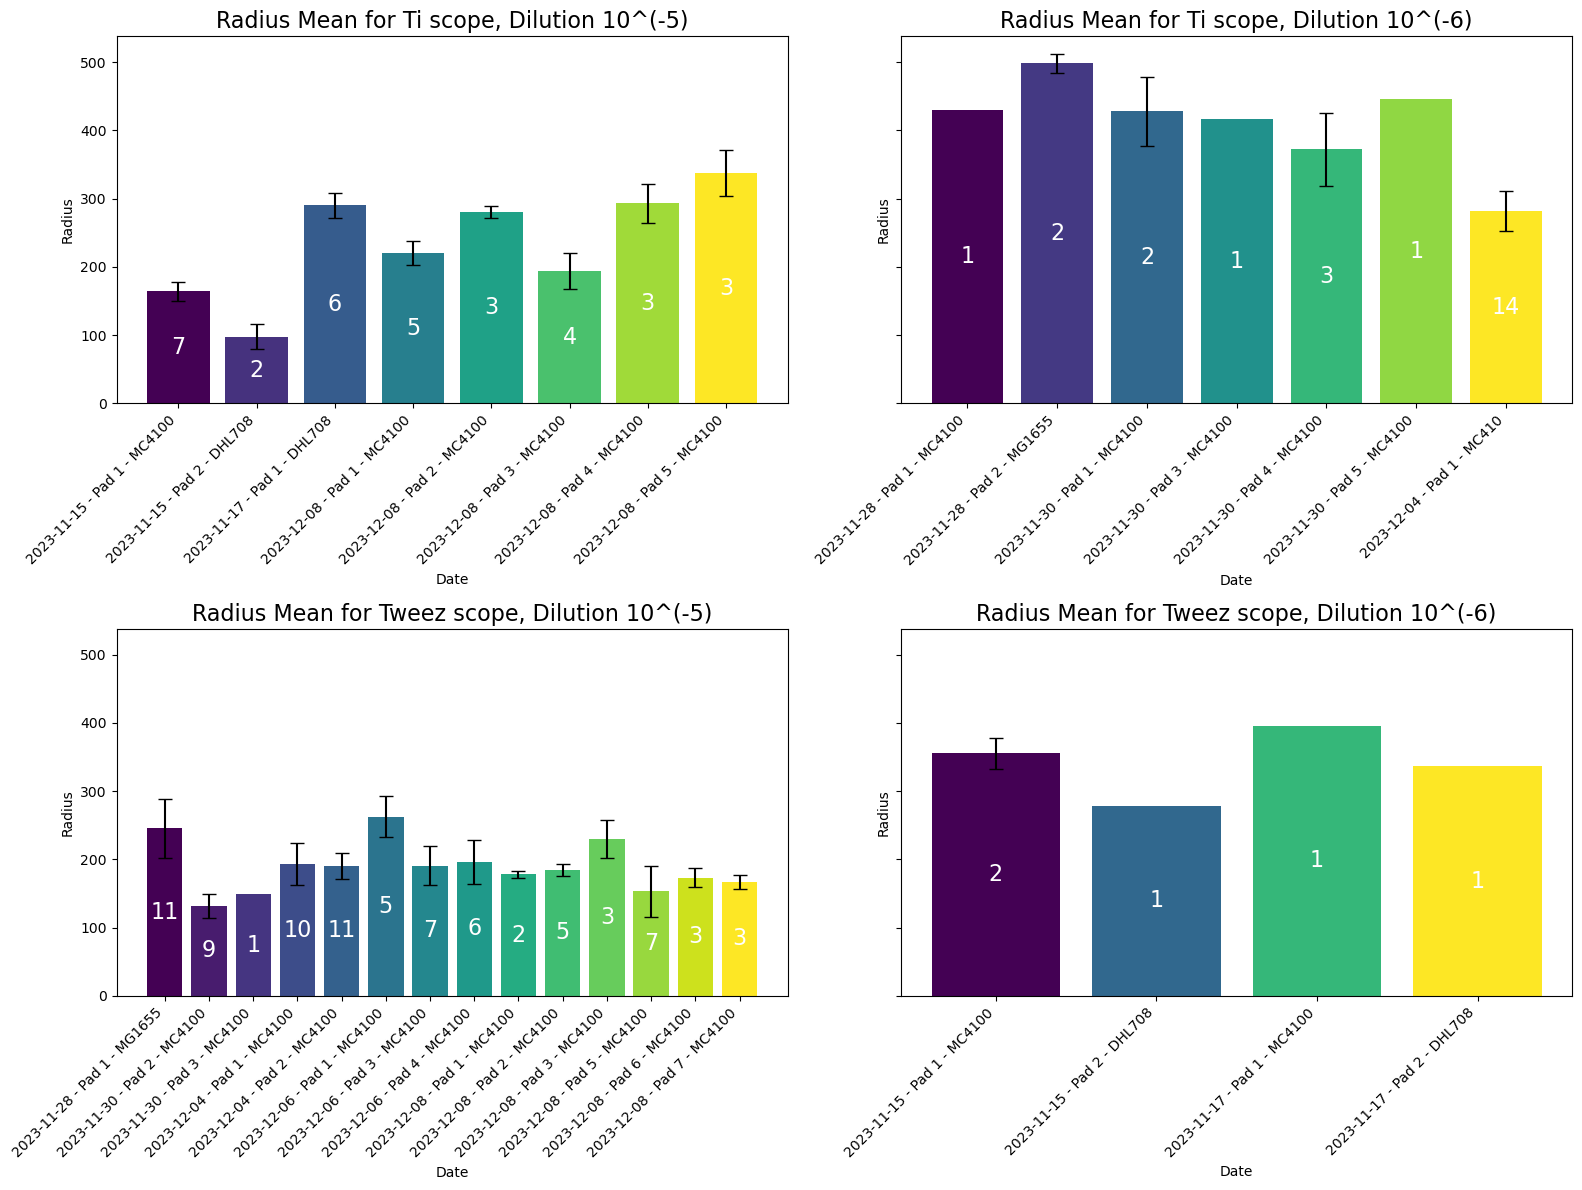

In [96]:
# Group the data by 'Date', 'Machine', 'Dilution', 'Pad', 'Strain' and calculate mean, standard deviation for 'radius' and count colonies
plot_data = df.groupby(['Date', 'Machine', 'Dilution', 'Pad', 'Strain']).agg({
    'radius': ['mean', 'std'],
    'Colonies': 'size'  # This will count the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Date', 'Machine', 'Dilution', 'Pad', 'Strain', 'Radius Mean', 'Radius Std', 'Colonies Count']

# Filter data for each machine and dilution type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
machine_dilutions = plot_data['Machine'].unique()
dilutions = plot_data['Dilution'].unique()

# Use a nested loop to create a subplot for each machine-dilution combination
for i, machine in enumerate(machine_dilutions):
    for j, dilution in enumerate(dilutions):
        sub_data = plot_data[(plot_data['Machine'] == machine) & (plot_data['Dilution'] == dilution)]
        if sub_data.empty:
            axes[i, j].set_xticks([])  # No data for this subplot
            continue
        radius_colors = plt.cm.viridis(np.linspace(0, 1, len(sub_data)))
        index = 0  # Initialize counter for the color array
        for _, row in sub_data.iterrows():
            bar = axes[i, j].bar(index, row['Radius Mean'], yerr=row['Radius Std'], capsize=5, color=radius_colors[index])
            # Annotate the number of colonies inside the bar
            axes[i, j].text(index, row['Radius Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=16)
            index += 1  # Increment counter
        
        axes[i, j].set_title(f'Radius Mean for {machine}, Dilution {dilution}', fontsize=16)
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Radius')
        axes[i, j].set_xticks(range(len(sub_data)))
        axes[i, j].set_xticklabels([f"{row['Date'].date()} - Pad {row['Pad']} - {row['Strain']}" for _, row in sub_data.iterrows()], rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [97]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

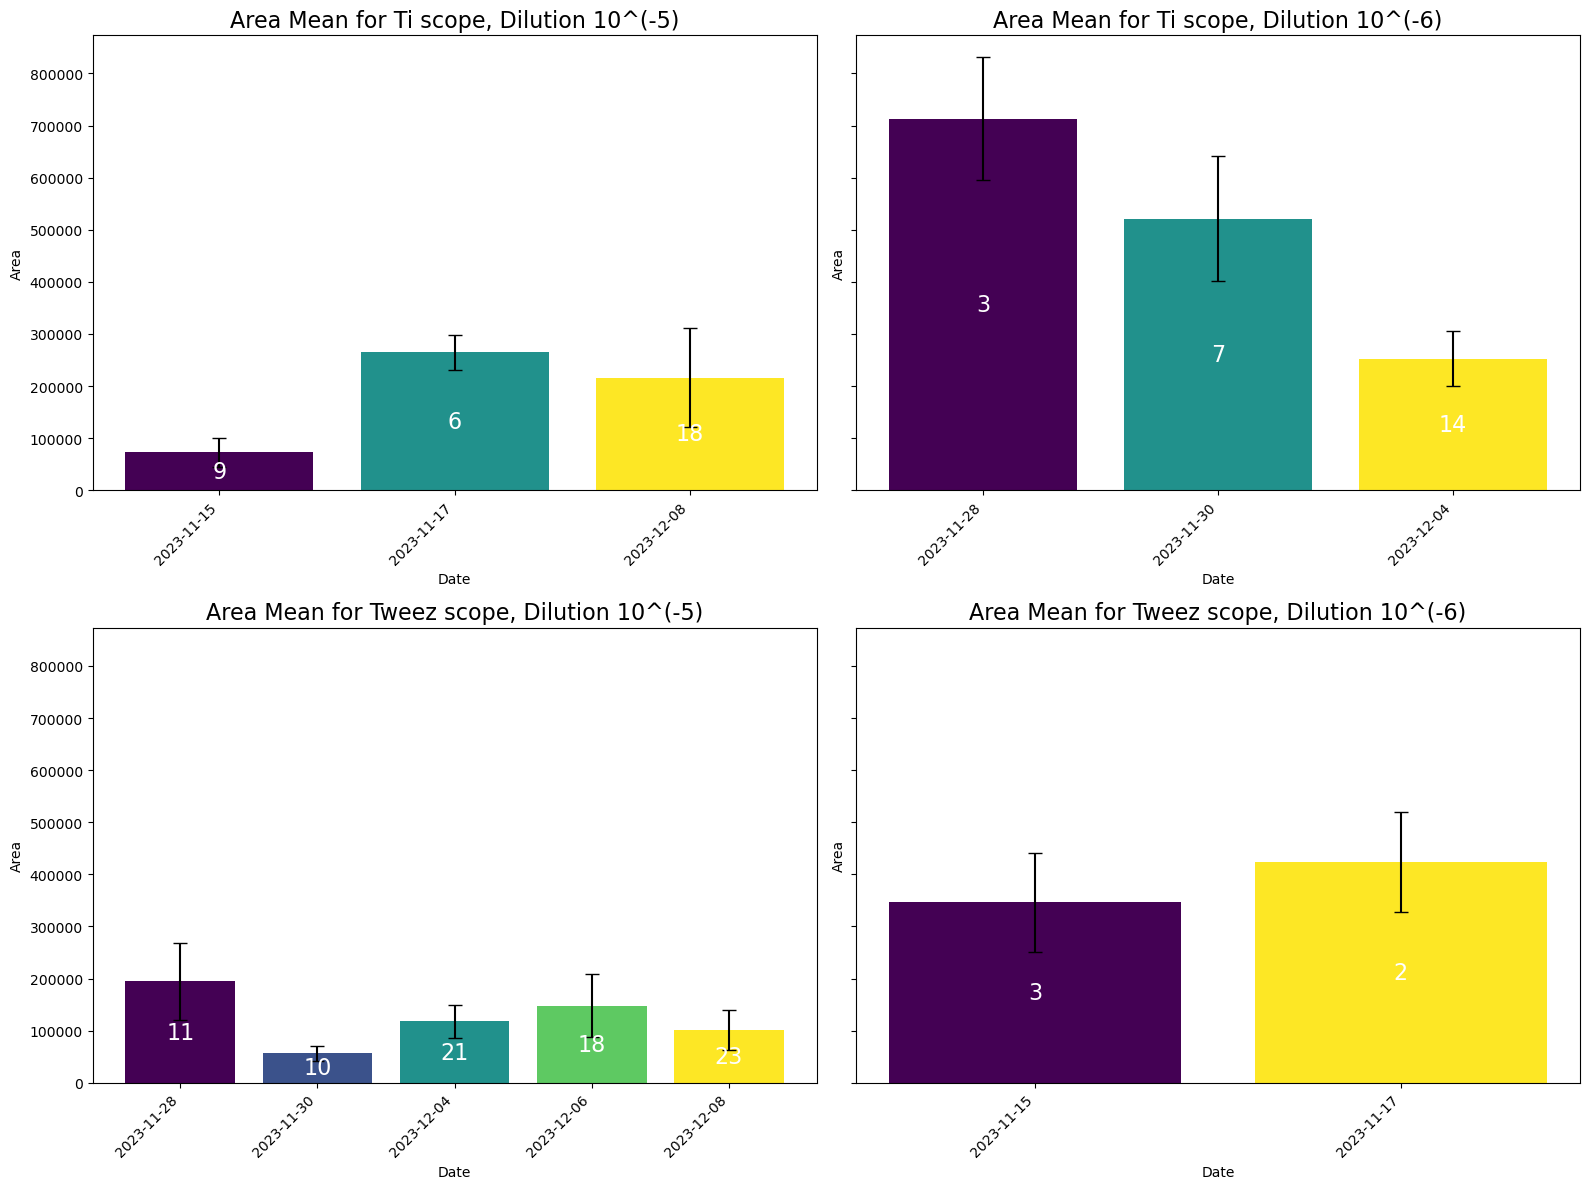

In [98]:
# Here we group by 'Date', 'Machine', 'Dilution' and calculate mean, standard deviation for 'area' and count colonies
plot_data = df.groupby(['Date', 'Machine', 'Dilution']).agg({
    'area': ['mean', 'std'],
    'Colonies': 'size'  # This will count the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Date', 'Machine', 'Dilution', 'Area Mean', 'Area Std', 'Colonies Count']

# Filter data for each machine and dilution type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
machine_dilutions = plot_data['Machine'].unique()
dilutions = plot_data['Dilution'].unique()

# Use a nested loop to create a subplot for each machine-dilution combination
for i, machine in enumerate(machine_dilutions):
    for j, dilution in enumerate(dilutions):
        sub_data = plot_data[(plot_data['Machine'] == machine) & (plot_data['Dilution'] == dilution)]
        if sub_data.empty:
            axes[i, j].set_xticks([])  # No data for this subplot
            continue
        area_colors = plt.cm.viridis(np.linspace(0, 1, len(sub_data)))
        index = 0  # Initialize counter for the color array
        for _, row in sub_data.iterrows():
            bar = axes[i, j].bar(index, row['Area Mean'], yerr=row['Area Std'], capsize=5, color=area_colors[index])
            # Annotate the number of colonies inside the bar
            axes[i, j].text(index, row['Area Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=16)
            index += 1  # Increment counter
        
        axes[i, j].set_title(f'Area Mean for {machine}, Dilution {dilution}', fontsize=16)
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Area')
        axes[i, j].set_xticks(range(len(sub_data)))
        axes[i, j].set_xticklabels([f"{row['Date'].date()}" for _, row in sub_data.iterrows()], rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [104]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

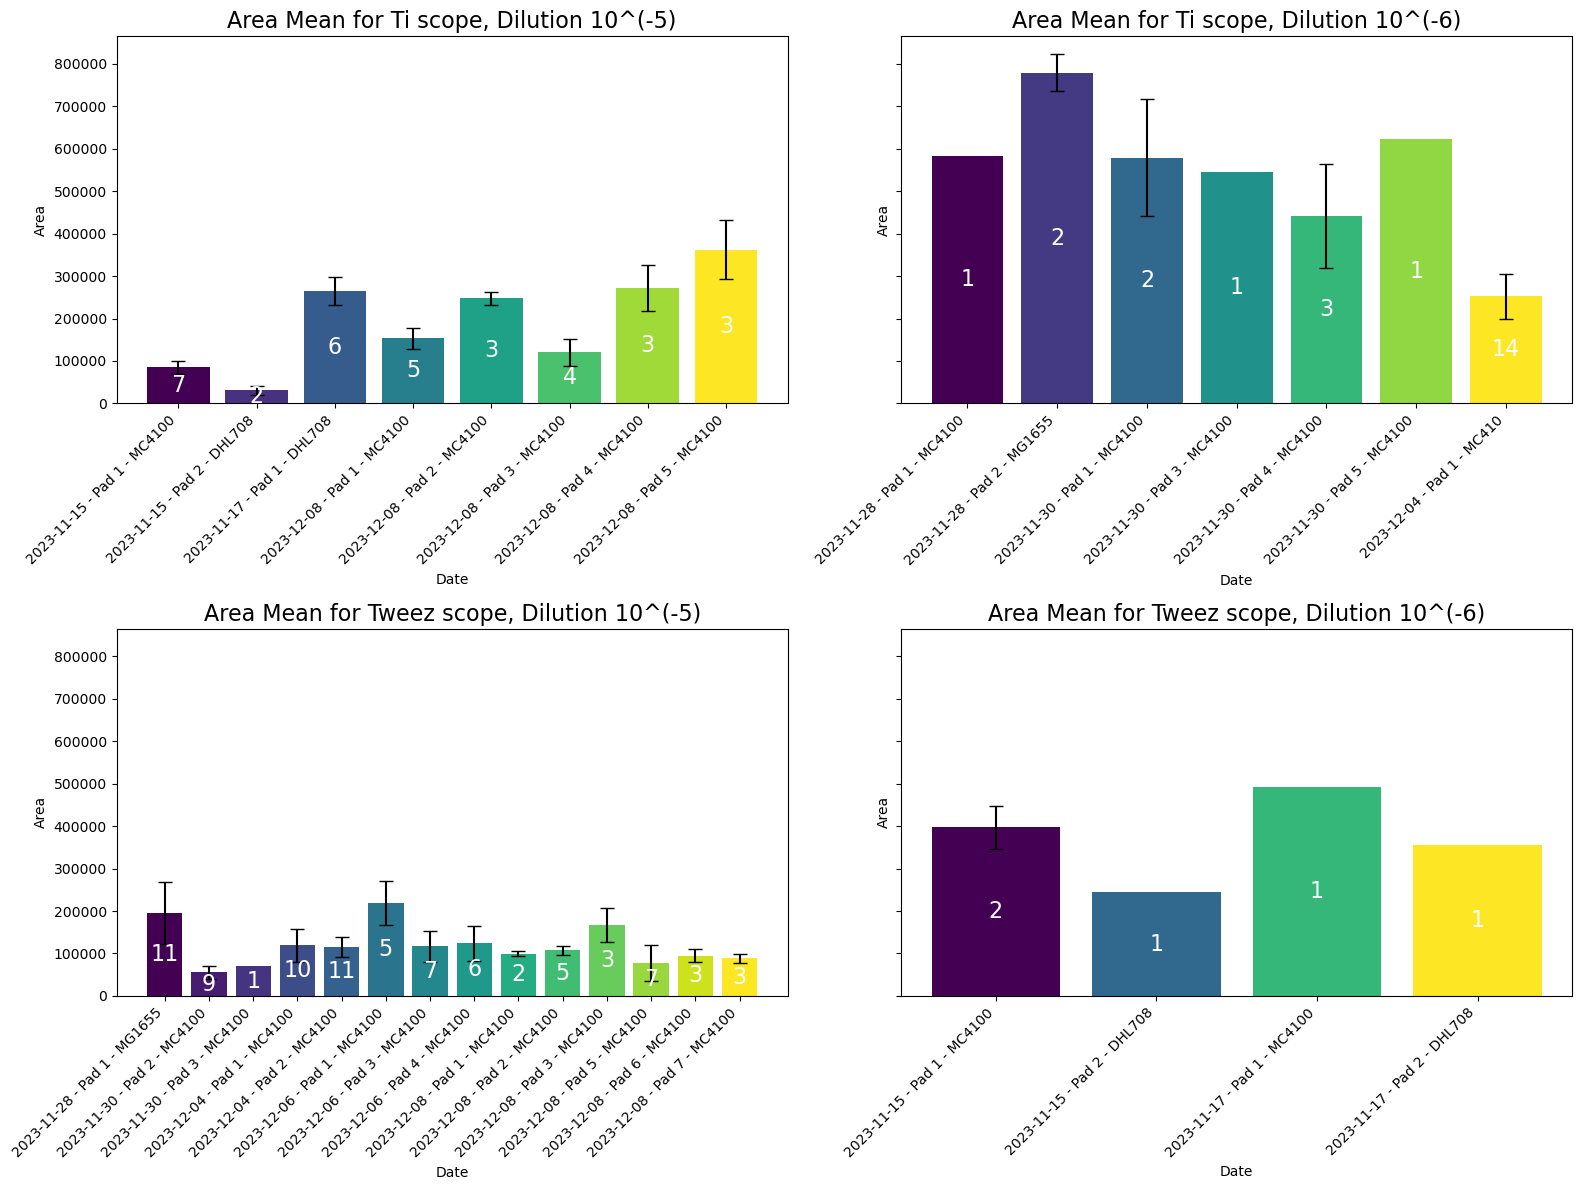

In [105]:
# Group the data by 'Date', 'Machine', 'Dilution', 'Pad', 'Strain' and calculate mean, standard deviation for 'area' and count colonies
plot_data = df.groupby(['Date', 'Machine', 'Dilution', 'Pad', 'Strain']).agg({
    'area': ['mean', 'std'],
    'Colonies': 'size'  # This will count the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Date', 'Machine', 'Dilution', 'Pad', 'Strain', 'Area Mean', 'Area Std', 'Colonies Count']

# Filter data for each machine and dilution type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
machine_dilutions = plot_data['Machine'].unique()
dilutions = plot_data['Dilution'].unique()

# Use a nested loop to create a subplot for each machine-dilution combination
for i, machine in enumerate(machine_dilutions):
    for j, dilution in enumerate(dilutions):
        sub_data = plot_data[(plot_data['Machine'] == machine) & (plot_data['Dilution'] == dilution)]
        if sub_data.empty:
            axes[i, j].set_xticks([])  # No data for this subplot
            continue
        area_colors = plt.cm.viridis(np.linspace(0, 1, len(sub_data)))
        index = 0  # Initialize counter for the color array
        for _, row in sub_data.iterrows():
            bar = axes[i, j].bar(index, row['Area Mean'], yerr=row['Area Std'], capsize=5, color=area_colors[index])
            # Annotate the number of colonies inside the bar
            axes[i, j].text(index, row['Area Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=16)
            index += 1  # Increment counter
        
        axes[i, j].set_title(f'Area Mean for {machine}, Dilution {dilution}', fontsize=16)
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Area')
        axes[i, j].set_xticks(range(len(sub_data)))
        axes[i, j].set_xticklabels([f"{row['Date'].date()} - Pad {row['Pad']} - {row['Strain']}" for _, row in sub_data.iterrows()], rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [101]:
df_out.loc[0, "radius"]

153.1699388299685

### Plot growth dynamics for all the colonies

In [161]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

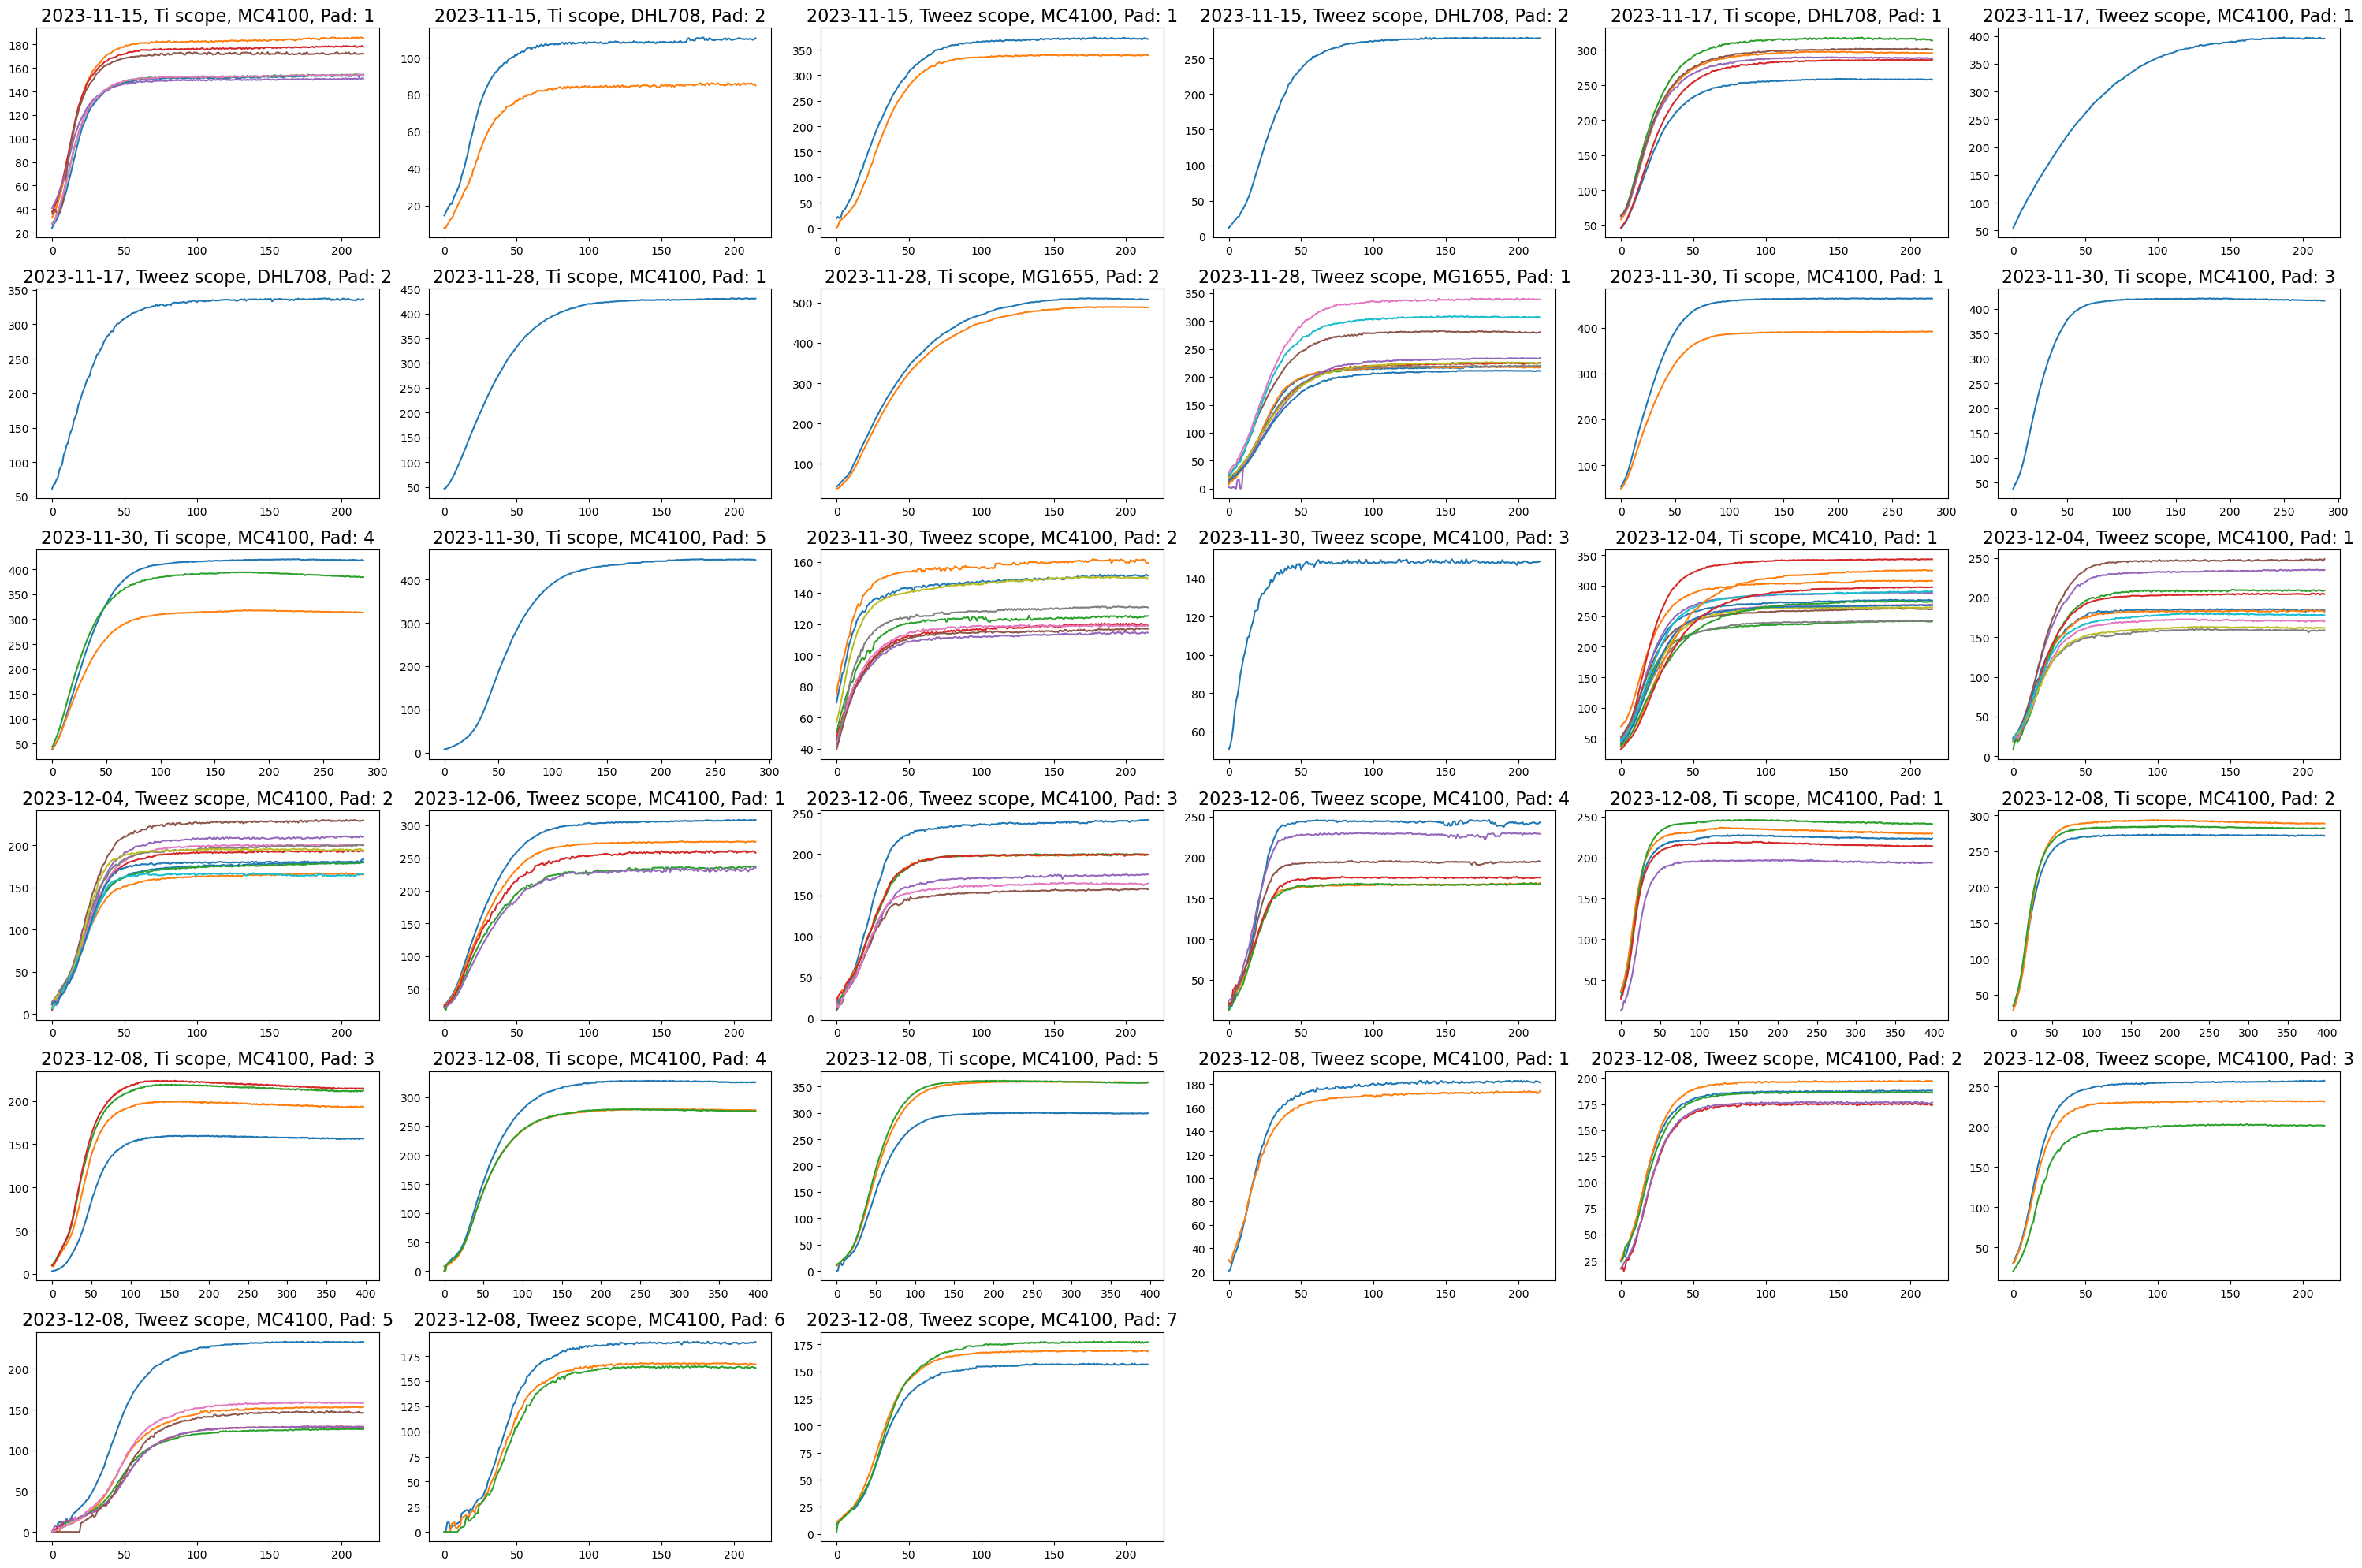

In [162]:
# Apply the extraction function to each row in the 'rad_dyn' column
df_out['rad_dyn'] = df_out['rad_dyn'].apply(extract_array)

# Group by 'Date', 'Machine', 'Pad', and 'Strain'
grouped = df_out.groupby(['Date', 'Machine', 'Pad', 'Strain'])

# Setup the plot - determine the layout based on the number of groups
group_count = len(grouped)
nrows = int(np.ceil(np.sqrt(group_count)))
ncols = int(np.ceil(group_count / nrows))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 20), squeeze=False)
axes = axes.flatten()

# Plot each group in a subplot
for ((date, machine, pad, strain), group), ax in zip(grouped, axes):
    for arr in group['rad_dyn']:
        ax.plot(arr)  # You might want to label these if needed
    # Format the date to only show year-month-day
    date_formatted = date.strftime('%Y-%m-%d')
    # Set the title to include the formatted date, machine name, pad, and strain
    ax.set_title(f'{date_formatted}, {machine}, {strain}, Pad: {pad}', fontsize=16)

# Hide any unused axes if there are any
for i in range(len(grouped), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [170]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

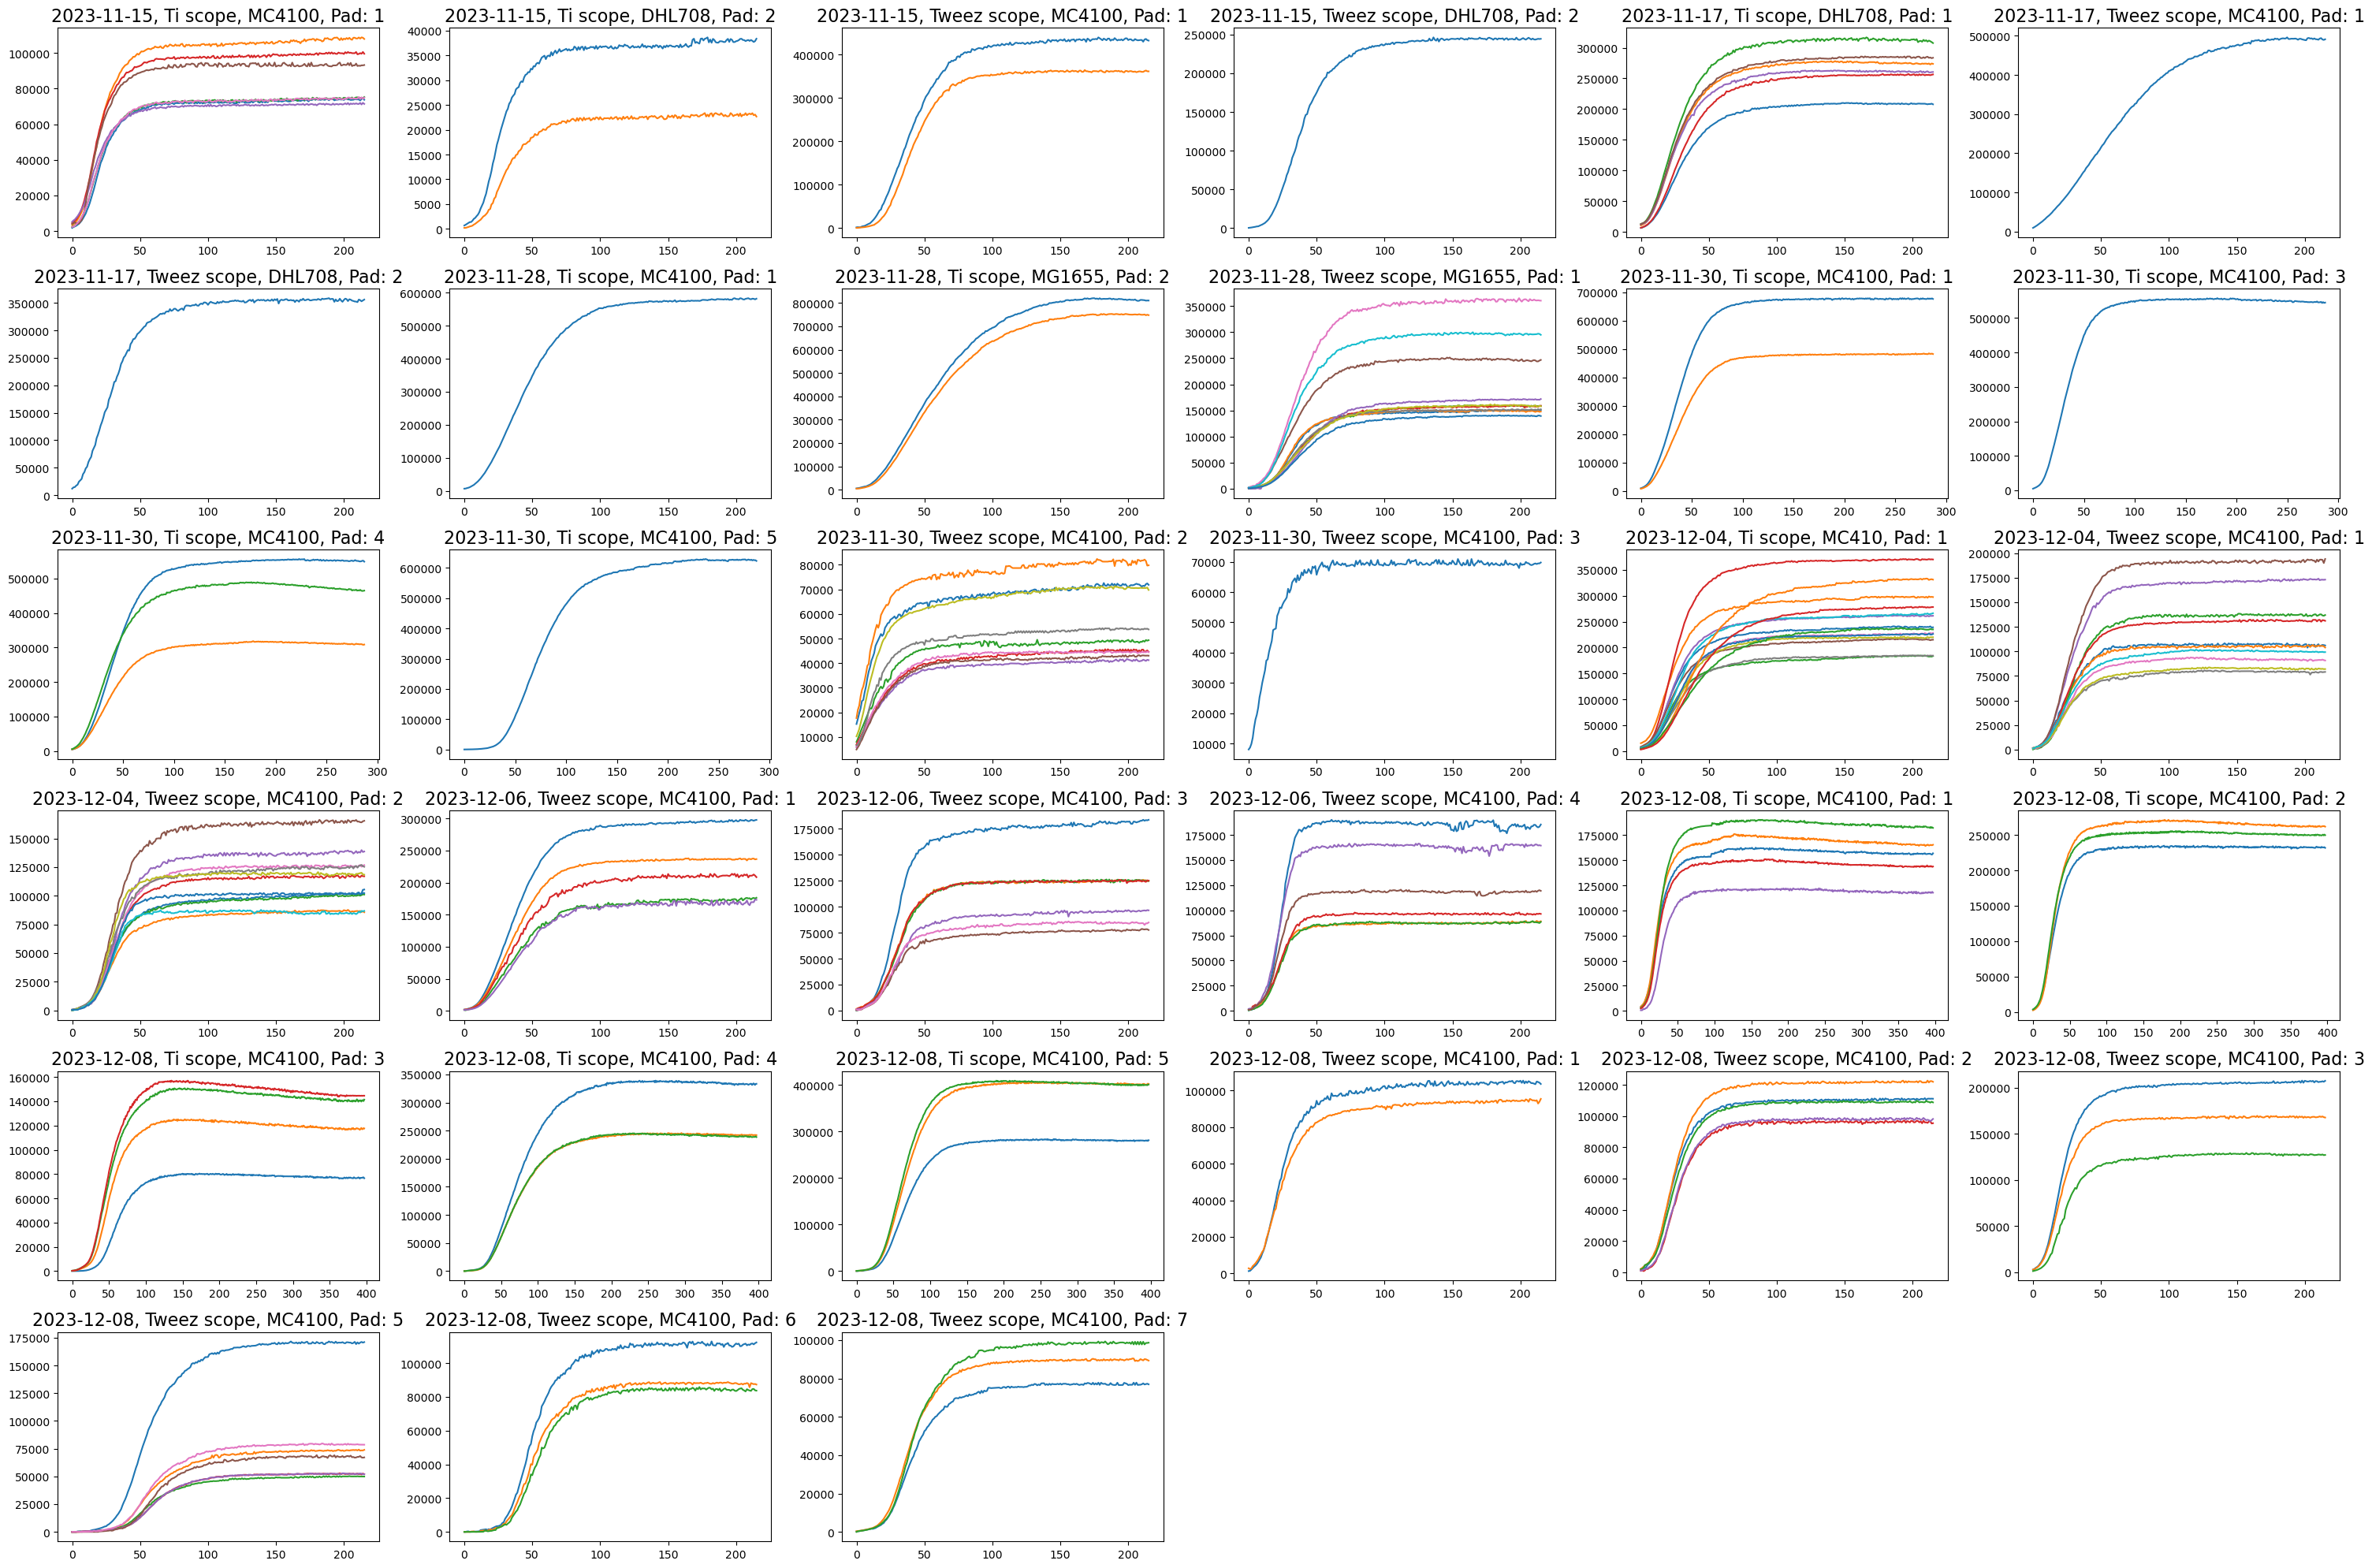

In [171]:
# Apply the extraction function to each row in the 'rad_dyn' column
df_out['area_dyn'] = df_out['area_dyn'].apply(extract_array)

# Group by 'Date', 'Machine', 'Pad', and 'Strain'
grouped = df_out.groupby(['Date', 'Machine', 'Pad', 'Strain'])

# Setup the plot - determine the layout based on the number of groups
group_count = len(grouped)
nrows = int(np.ceil(np.sqrt(group_count)))
ncols = int(np.ceil(group_count / nrows))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 20), squeeze=False)
axes = axes.flatten()

# Plot each group in a subplot
for ((date, machine, pad, strain), group), ax in zip(grouped, axes):
    for arr in group['area_dyn']:
        ax.plot(arr)  # You might want to label these if needed
    # Format the date to only show year-month-day
    date_formatted = date.strftime('%Y-%m-%d')
    # Set the title to include the formatted date, machine name, pad, and strain
    ax.set_title(f'{date_formatted}, {machine}, {strain}, Pad: {pad}', fontsize=16)

# Hide any unused axes if there are any
for i in range(len(grouped), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [165]:
# I can continue doing this with average growth rate, dynamical growth rate, etc
- rate of change of the radius (vfront) = dR/dt
- av growth rate = 1/A dA/dt

In [ ]:
Histograms of two dilutions, overall view
group by strain as well
analogy of cell dividing after reaching length or time? use the same for colonies on a pad

Fit area growth to Logistic, gompertz, check diff models from tims paper, include lag phase as well

In [200]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

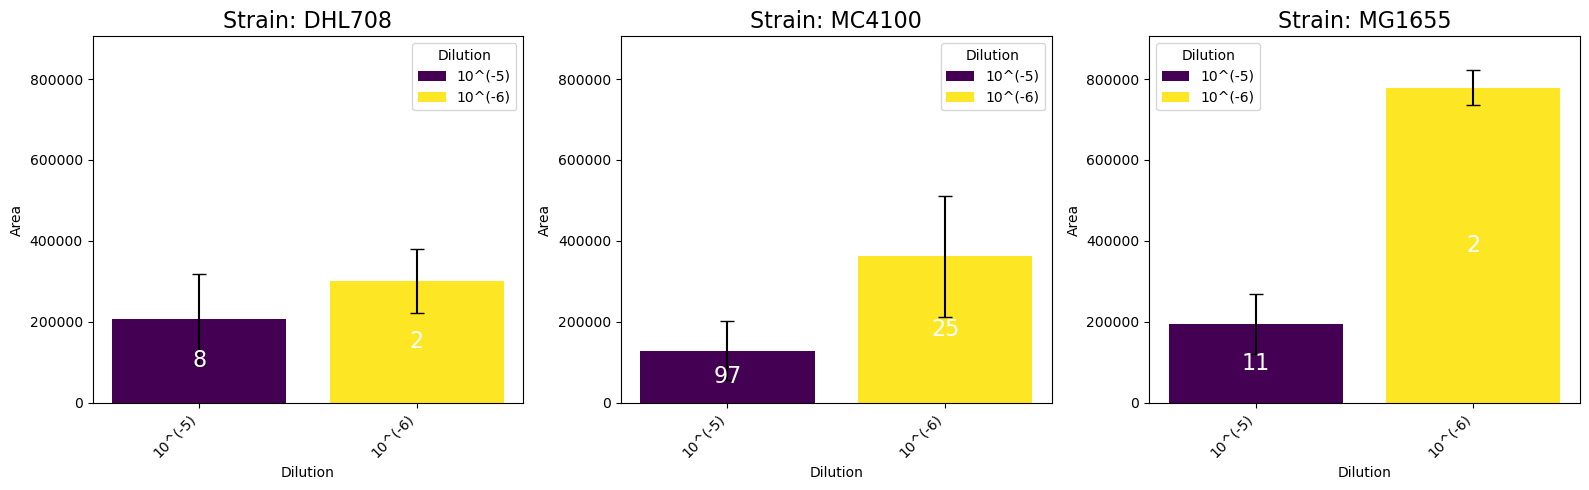

In [199]:
# Group the data by 'Strain', 'Dilution', and calculate mean, standard deviation for 'area' and count colonies
plot_data = df.groupby(['Strain', 'Dilution']).agg({
    'area': ['mean', 'std'],
    'Colonies': 'size'  # This will count the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Strain', 'Dilution', 'Area Mean', 'Area Std', 'Colonies Count']

# Find the global maximum for the y-axis
max_area = plot_data['Area Mean'] + plot_data['Area Std']
global_max = max_area.max()

# Determine the number of subplots needed
unique_strains = plot_data['Strain'].unique()
subplot_count = len(unique_strains)
fig, axes = plt.subplots(nrows=1, ncols=subplot_count, figsize=(16, 5), squeeze=False)
axes = axes.flatten()  # Flatten the axes array for easier access

# Plot each strain's dilution data side by side
for ax, strain in zip(axes, unique_strains):
    sub_data = plot_data[plot_data['Strain'] == strain]
    dilutions = sub_data['Dilution'].unique()
    area_colors = plt.cm.viridis(np.linspace(0, 1, len(dilutions)))
    
    # Plot each dilution for the current strain
    for idx, dilution in enumerate(dilutions):
        dilution_data = sub_data[sub_data['Dilution'] == dilution]
        for i, row in dilution_data.iterrows():
            ax.bar(idx, row['Area Mean'], yerr=row['Area Std'], capsize=5, color=area_colors[idx], label=dilution)
            # Annotate the number of colonies inside the bar
            ax.text(idx, row['Area Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=16)

    ax.set_title(f'Strain: {strain}', fontsize=16)
    ax.set_xlabel('Dilution')
    ax.set_ylabel('Area')
    ax.set_xticks(np.arange(len(dilutions)))
    ax.set_xticklabels(dilutions, rotation=45, ha="right")
    ax.legend(title="Dilution")
    ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits

# Hide any unused axes
for i in range(len(unique_strains), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [237]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

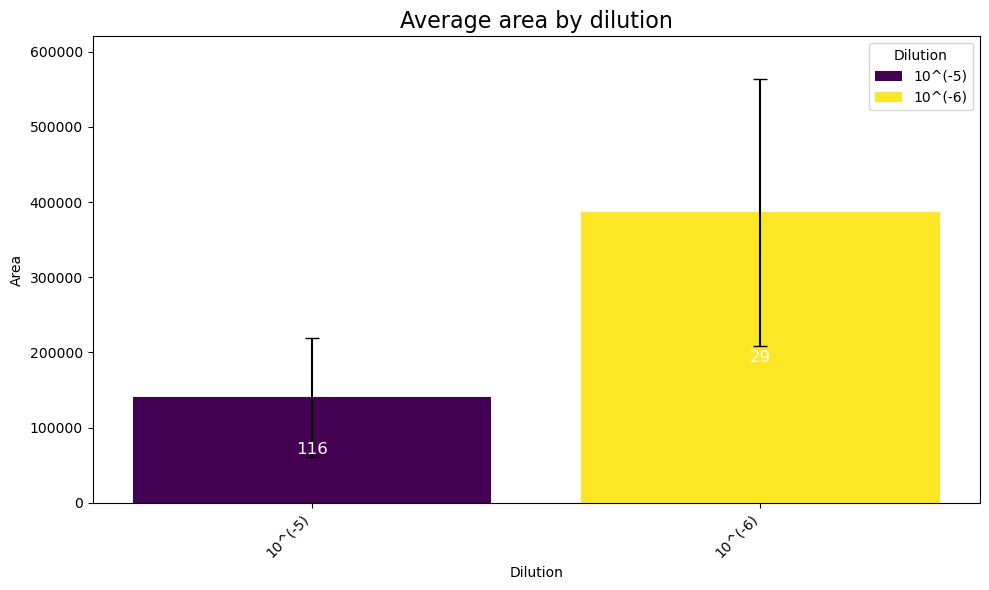

In [238]:
# Group the data by 'Dilution' only, and calculate mean, standard deviation for 'area' and count colonies
plot_data = df.groupby(['Dilution']).agg({
    'area': ['mean', 'std'],
    'Colonies': 'size'  # This counts the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Dilution', 'Area Mean', 'Area Std', 'Colonies Count']

# Find the global maximum for the y-axis to ensure proper scale
max_area = plot_data['Area Mean'] + plot_data['Area Std']
global_max = max_area.max()

# Create a single plot for all dilutions
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color range
area_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

# Plot each dilution
for idx, row in plot_data.iterrows():
    ax.bar(idx, row['Area Mean'], yerr=row['Area Std'], capsize=5, color=area_colors[idx], label=row['Dilution'])
    # Annotate the number of colonies inside the bar
    ax.text(idx, row['Area Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)

ax.set_title('Average area by dilution', fontsize=16)
ax.set_xlabel('Dilution')
ax.set_ylabel('Area')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.legend(title="Dilution")

plt.tight_layout()
plt.show()

fig.savefig('Av_area_dil_bar.png', dpi=300)

In [239]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

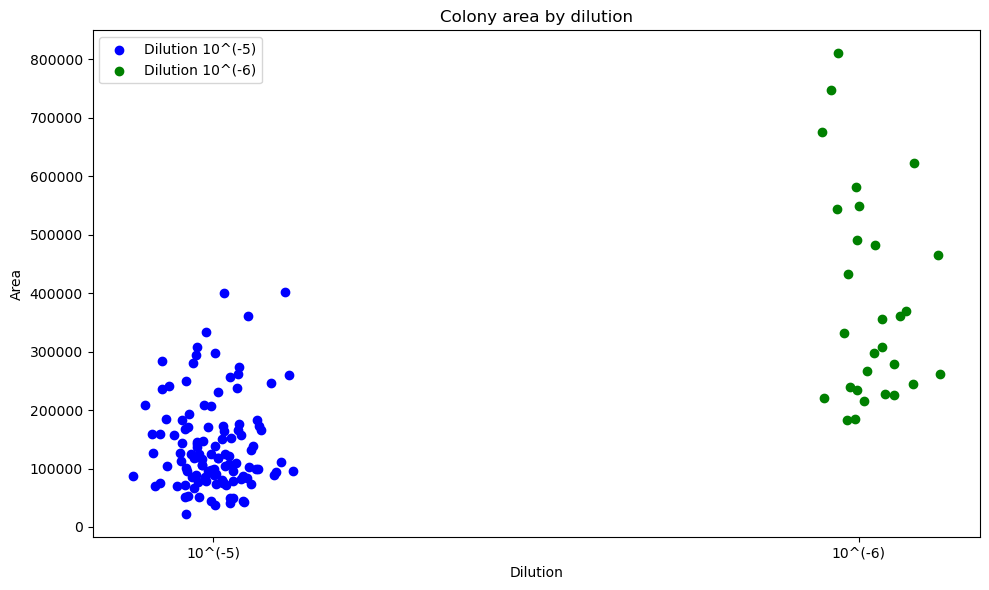

In [240]:
# Colors for each dilution
colors = ['blue', 'green']
dilutions = df['Dilution'].unique()

# Plot with distinct areas for each dilution
fig, ax = plt.subplots(figsize=(10, 6))

for i, dilution in enumerate(dilutions):
    # Create an offset for x positions to visually separate data
    x_positions = np.random.normal(i, 0.05, size=len(df[df['Dilution'] == dilution]))
    sub_data = df[df['Dilution'] == dilution]
    ax.scatter(x_positions, sub_data['area'], color=colors[i], label=f'Dilution {dilution}')

ax.set_title('Colony area by dilution')
ax.set_xlabel('Dilution')
ax.set_ylabel('Area')
ax.set_xticks(np.arange(len(dilutions)))
ax.set_xticklabels(dilutions)
ax.legend()

plt.tight_layout()
plt.show()

fig.savefig('Area_dil_scatter.png', dpi=300)


Make histograms of the above

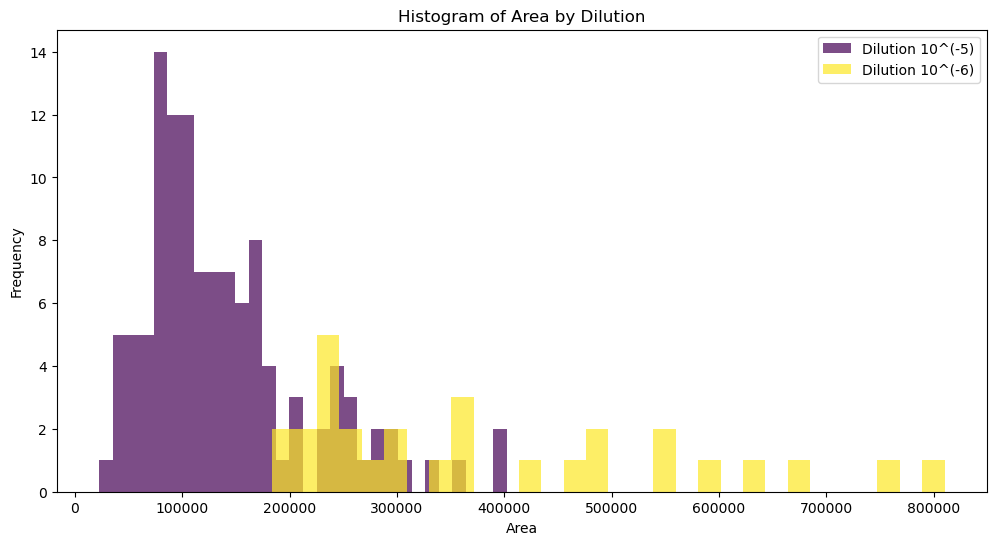

In [128]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# Assuming there are exactly two dilution groups
dilutions = df['Dilution'].unique()
data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()

colors = plt.cm.viridis(np.linspace(0, 1, len(dilutions)))

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for the first dilution
plt.hist(data1, bins=30, alpha=0.7, label=f'Dilution {dilutions[0]}', color=colors[0])

# Histogram for the second dilution
plt.hist(data2, bins=30, alpha=0.7, label=f'Dilution {dilutions[1]}', color=colors[1])

plt.title('Histogram of Area by Dilution')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('His_Area_dil.png', dpi=300)
plt.show()



In [219]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# ANOVA test for more than two dilutions
if df['Dilution'].nunique() > 2:
    # Create groups for each dilution
    groups = [group['area'].dropna() for name, group in df.groupby('Dilution')]
    # Perform ANOVA
    f_val, p_val = stats.f_oneway(*groups)
    print("ANOVA test results: F =", f_val, ", P =", p_val)

# Two dilution groups
elif df['Dilution'].nunique() == 2:
    dilutions = df['Dilution'].unique()
    data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
    data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(data1, data2)
    print("T-test results: t =", t_stat, ", P =", p_val)

# Additional checks for assumptions (normality check for t-test)
if df['Dilution'].nunique() == 2:
    print("Normality Test for group 1:", stats.shapiro(data1))
    print("Normality Test for group 2:", stats.shapiro(data2))


T-test results: t = -11.1916567831005 , P = 2.8255489504278984e-21
Normality Test for group 1: ShapiroResult(statistic=0.8948546800667634, pvalue=1.597732944686496e-07)
Normality Test for group 2: ShapiroResult(statistic=0.8956199441658065, pvalue=0.007707217791473738)


2

In [ ]:
T-test Results
t-statistic = -11.1916567831005: This value is quite far from zero, indicating a significant difference between the means of the two groups.
The negative sign indicates that the mean of the first group is less than the mean of the second group.
P-value = 2.8255489504278984e-21: This extremely small p-value (far less than 0.05) strongly suggests that the differences in means 
between the two groups are statistically significant. In simpler terms, you can reject the null hypothesis that there is no difference 
between the means of the two groups, and conclude that the dilution levels do have a significant effect on the area.

Normality Test Results
Group 1:
Shapiro-Wilk Statistic = 0.8948546800667634
P-value = 1.597732944686496e-07: This p-value is less than 0.05, indicating that the data for this group does not follow a normal 
distribution.
Group 2:
Shapiro-Wilk Statistic = 0.8956199441658065
P-value = 0.007707217791473738: Similarly, this p-value is also less than 0.05, suggesting that the data for this group are not 
normally distributed either.


In [220]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# Assuming there are exactly two dilution groups
dilutions = df['Dilution'].unique()
data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()

# Perform Mann-Whitney U test
u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')

print("Mann-Whitney U test results: U =", u_stat, ", P =", p_val)


Mann-Whitney U test results: U = 225.0 , P = 6.047524766825691e-13


In [ ]:
Interpretation:
Statistically Significant Difference: The very low p-value indicates strong evidence against the null hypothesis of the Mann-Whitney U test,
which states that there is a 50% chance that an observation from one group will be larger than an observation from the other group. 
Since the p-value is much smaller than 0.05, you can reject the null hypothesis.

Effect of Dilutions on Area: The results suggest that the dilution levels have a statistically significant effect on the area measurements. 
This means that the differences in area are not likely due to random chance, and there is a systematic difference in area between the two 
dilution groups being tested.
Practical Implications:
Decision Making: Based on this test, if you are in a situation where you are choosing between two dilution treatments (assuming these are the ones tested), there is statistically significant evidence to suggest that one of them leads to a different outcome in terms of area than the other.
Further Research: While the test indicates differences, it doesn't specify which group has the higher area. Further detailed analysis or additional data visualization could help in understanding the direction of this difference (e.g., examining the mean ranks or plotting the distributions). Moreover, examining why these differences occur could be beneficial in a practical setting.
Next Steps:
Examine the Data Further: You might want to look more closely at how the area values are distributed within each group to understand the nature of the differences — are they skewed, do they have outliers, etc.?
Consider Additional Factors: If there are more variables in your dataset, consider whether other factors might influence the relationship between dilution and area. Multivariable statistical methods or regression analysis could provide deeper insights.
This test provides a robust method for determining whether the differences observed in your study are statistically significant, helping guide further research and decision-making processes.

In [223]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# Assuming there are exactly two dilution groups
dilutions = df['Dilution'].unique()
data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()

# Shapiro-Wilk Test for normality
shapiro_test1 = stats.shapiro(data1)
shapiro_test2 = stats.shapiro(data2)

print(f'Shapiro-Wilk Test for group 1: {shapiro_test1}')
print(f'Shapiro-Wilk Test for group 2: {shapiro_test2}')

# Kolmogorov-Smirnov Test assuming normal distribution
# First, get the normal distribution parameters (mean and std) from the data
ks_test1 = stats.kstest(data1, 'norm', args=(data1.mean(), data1.std()))
ks_test2 = stats.kstest(data2, 'norm', args=(data2.mean(), data2.std()))

print(f'Kolmogorov-Smirnov Test for group 1: {ks_test1}')
print(f'Kolmogorov-Smirnov Test for group 2: {ks_test2}')

# Anderson-Darling Test for normality
anderson_test1 = stats.anderson(data1, dist='norm')
anderson_test2 = stats.anderson(data2, dist='norm')

print(f'Anderson-Darling Test for group 1: {anderson_test1}')
print(f'Anderson-Darling Test for group 2: {anderson_test2}')


Shapiro-Wilk Test for group 1: ShapiroResult(statistic=0.8948546800667634, pvalue=1.597732944686496e-07)
Shapiro-Wilk Test for group 2: ShapiroResult(statistic=0.8956199441658065, pvalue=0.007707217791473738)
Kolmogorov-Smirnov Test for group 1: KstestResult(statistic=0.14390272693078227, pvalue=0.014689568872366082, statistic_location=127239, statistic_sign=1)
Kolmogorov-Smirnov Test for group 2: KstestResult(statistic=0.15757983015701593, pvalue=0.4238651314229607, statistic_location=370160, statistic_sign=1)
Anderson-Darling Test for group 1: AndersonResult(statistic=3.8128734039981538, critical_values=array([0.558, 0.635, 0.762, 0.889, 1.057]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=140464.3448275862, scale=79191.8199571366)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Anderson-Darling Test for group 2: AndersonResult(statistic=1.0579504101067485, critical_values=array([0.52 , 0.592, 0.71

In [ ]:
1. Shapiro-Wilk Test:
Group 1:
Statistic: 0.8948546800667634
P-value: 1.597732944686496e-07
Group 2:
Statistic: 0.8956199441658065
P-value: 0.007707217791473738
Both groups have a p-value less than 0.05, indicating strong evidence against the null hypothesis that the data is normally distributed. 
Thus, the data in both groups are not normally distributed.

2. Kolmogorov-Smirnov Test:
Group 1:
Statistic: 0.14390272693078227
P-value: 0.014689568872366082
Group 2:
Statistic: 0.15757983015701593
P-value: 0.4238651314229607
For Group 1, the p-value is below 0.05, suggesting that the data does not fit the normal distribution used as the model (with the same 
mean and standard deviation as the sample). For Group 2, the p-value is above 0.05, indicating insufficient evidence to reject the 
hypothesis that the data follows the modeled normal distribution; however, this does not confirm normality, especially considering the 
results from other tests.

3. Anderson-Darling Test:
Group 1:
Statistic: 3.8128734039981538
Critical Values: [0.558, 0.635, 0.762, 0.889, 1.057] for significance levels [15%, 10%, 5%, 2.5%, 1%]
Group 2:
Statistic: 1.0579504101067485
Critical Values: [0.52, 0.592, 0.71, 0.828, 0.985] for significance levels [15%, 10%, 5%, 2.5%, 1%]
For both groups, the test statistic exceeds the critical values at a 5% significance level, suggesting the data do not follow a 
normal distribution. This aligns with the Shapiro-Wilk test results and supports the non-normality of the data.

Conclusion:
All tests converge to the same conclusion that the data in both groups do not follow a normal distribution. This influences which 
types of statistical tests should be applied for further analysis, guiding you toward non-parametric methods for any comparative or 
correlative analysis involving these data sets.

- Make plots of 1/A dA/dt (peak average growth rate), compare bar graphs of that as well
- When the colony is smaller the peak growth rate goes up, when the colony is smaller it growths much more quicker.
- High dilutions low growth rates and low dilutions high growth
- Calculate 1/A dA/dt, smooth it out, fin the peak and use it as the value in the bar graph

Overall:
- They grow to bigger colonies in lower dilutions
- They grow faster in slower dilutions (high density)

In [135]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

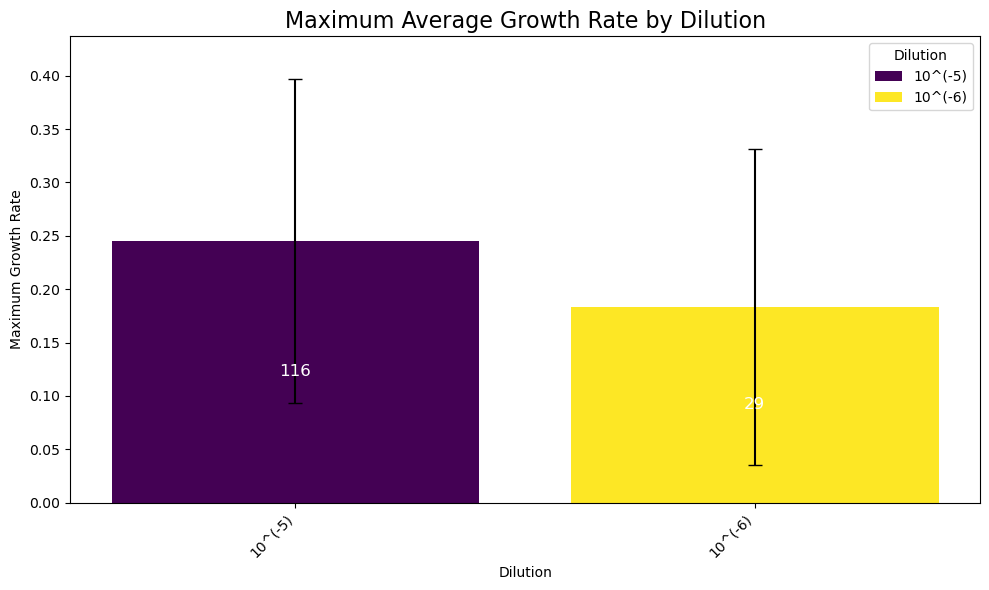

In [136]:
# Group the data by 'Dilution' only, and calculate mean, standard deviation for 'max_av_gr' and count colonies
plot_data = df.groupby(['Dilution']).agg({
    'max_av_gr': ['mean', 'std'],
    'Colonies': 'size'  # This counts the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Dilution', 'Max Av GR Mean', 'Max Av GR Std', 'Colonies Count']

# Find the global maximum for the y-axis to ensure proper scale
max_growth = plot_data['Max Av GR Mean'] + plot_data['Max Av GR Std']
global_max = max_growth.max()

# Create a single plot for all dilutions
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color range
growth_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

# Plot each dilution
for idx, row in plot_data.iterrows():
    ax.bar(idx, row['Max Av GR Mean'], yerr=row['Max Av GR Std'], capsize=5, color=growth_colors[idx], label=row['Dilution'])
    # Annotate the number of colonies inside the bar
    ax.text(idx, row['Max Av GR Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)

ax.set_title('Maximum Average Growth Rate by Dilution', fontsize=16)
ax.set_xlabel('Dilution')
ax.set_ylabel('Maximum Growth Rate')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.legend(title="Dilution")

plt.tight_layout()
plt.show()

fig.savefig('Max_Av_GR_Dil_Bar.png', dpi=300)


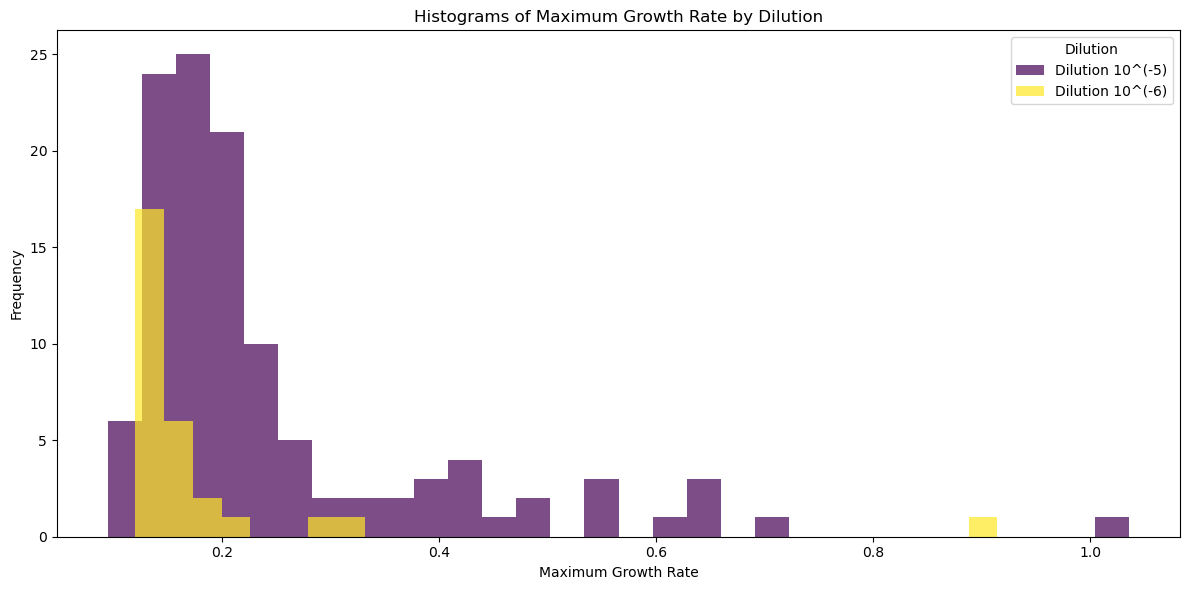

In [134]:
# Ensure that 'max_av_gr' contains only finite values
df = df[np.isfinite(df['max_av_gr'])]  # Filter to keep only rows where 'max_av_gr' is finite

# Retrieve unique dilutions to create histograms for each
unique_dilutions = df['Dilution'].unique()

# Set up the plot
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_dilutions)))

# Plot histograms for each dilution
for i, dilution in enumerate(unique_dilutions):
    data = df[df['Dilution'] == dilution]['max_av_gr']
    plt.hist(data, bins=30, alpha=0.7, label=f'Dilution {dilution}', color=colors[i])

plt.title('Histograms of Maximum Growth Rate by Dilution')
plt.xlabel('Maximum Growth Rate')
plt.ylabel('Frequency')
plt.legend(title="Dilution")
plt.savefig('His_Max_Av_GR_dil.png', dpi=300)
plt.tight_layout()
plt.show()


### Fit Gompertz

In [160]:
from scipy.optimize import curve_fit

In [220]:
def extract_array(s):
    numbers = re.findall(r"[-+]?\d*\.?\d+e[-+]?\d+|[-+]?\d*\.?\d+", s)
    return np.array([float(num) for num in numbers])

In [233]:
def gompertz(t, A, mu_m, lambda_):
    return A * np.exp(-np.exp(mu_m * np.e / A * (lambda_ - t) + 1))

In [166]:
df.loc[i, 'exp length']

406

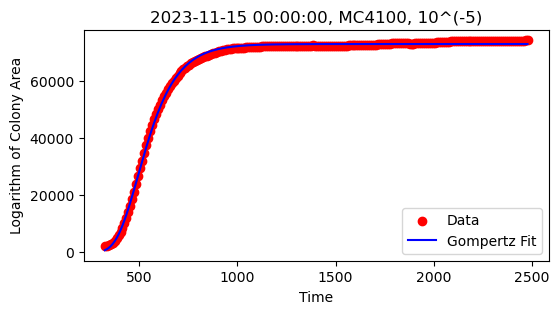

Fitted parameters [A, mu_m, lambda]: [72753.40082784   243.06204255   385.0040092 ], i: 0


/tmp/ipykernel_302403/726598630.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{"A": 72753.4, "mu_m": 243.06, "lambda": 385.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'gomp_params'] = json.dumps(pars_dict)


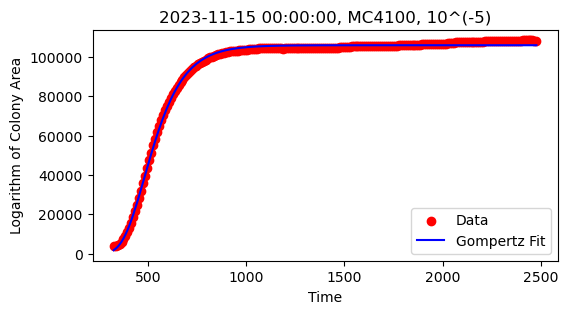

Fitted parameters [A, mu_m, lambda]: [105881.24258818    349.81843778    371.62251459], i: 1


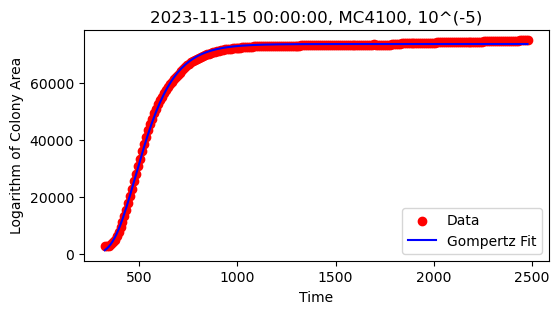

Fitted parameters [A, mu_m, lambda]: [73546.27343318   241.73247091   369.48985723], i: 2


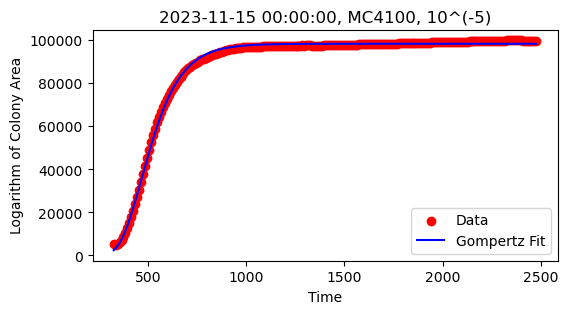

Fitted parameters [A, mu_m, lambda]: [98385.37772825   330.12098302   359.80015086], i: 3


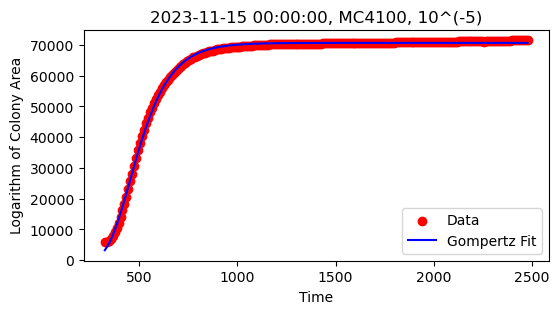

Fitted parameters [A, mu_m, lambda]: [70693.4427293    227.83211398   340.30636275], i: 4


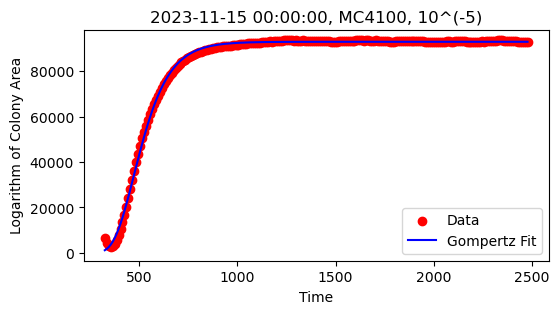

Fitted parameters [A, mu_m, lambda]: [92987.70085232   341.57597322   374.16149695], i: 5


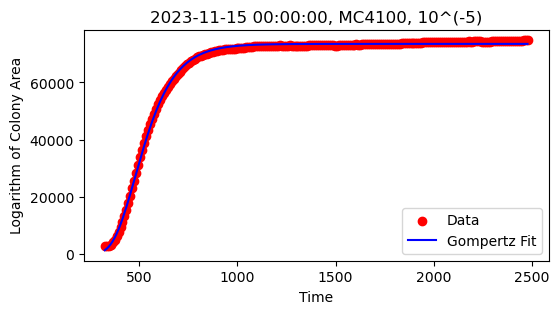

Fitted parameters [A, mu_m, lambda]: [73467.22888644   242.74093804   369.36743056], i: 6


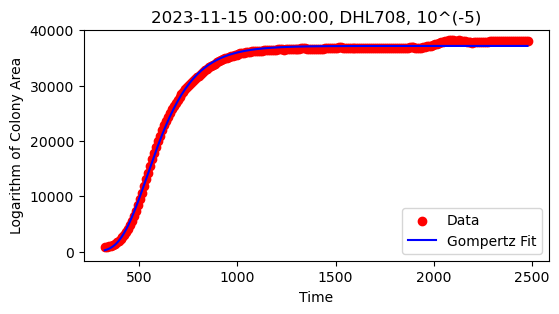

Fitted parameters [A, mu_m, lambda]: [37150.81775061   102.25915138   407.77844593], i: 7


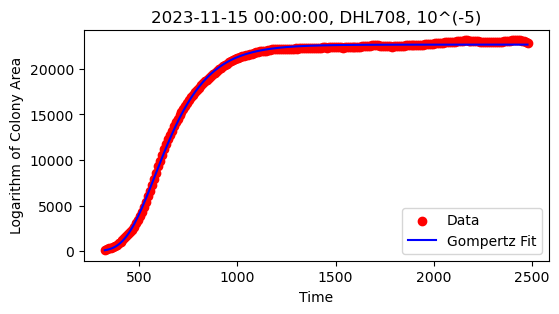

Fitted parameters [A, mu_m, lambda]: [22670.56685556    55.31712018   431.60690959], i: 8


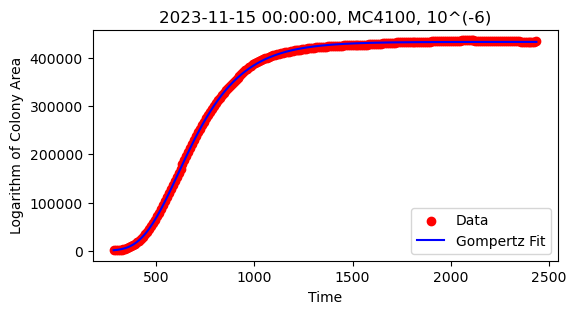

Fitted parameters [A, mu_m, lambda]: [4.33256340e+05 8.79560475e+02 4.31249994e+02], i: 9


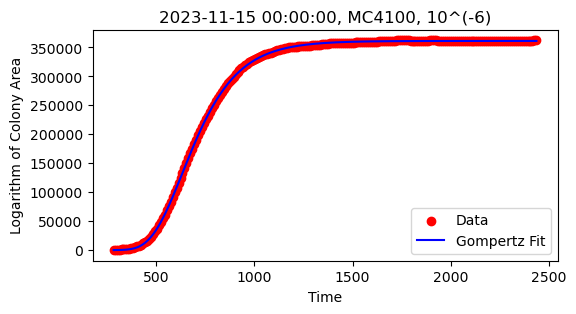

Fitted parameters [A, mu_m, lambda]: [361326.44812821    846.85076558    477.47500462], i: 10


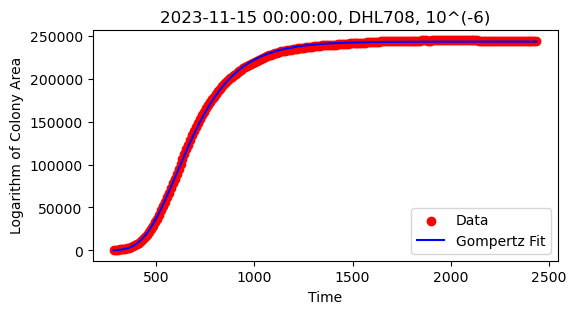

Fitted parameters [A, mu_m, lambda]: [243116.32386554    542.35725749    440.01883814], i: 11


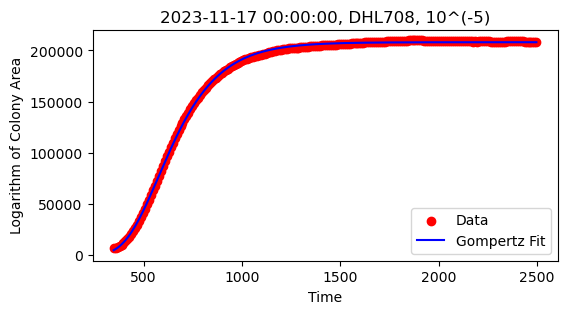

Fitted parameters [A, mu_m, lambda]: [207999.25228749    446.26231409    403.37344571], i: 12


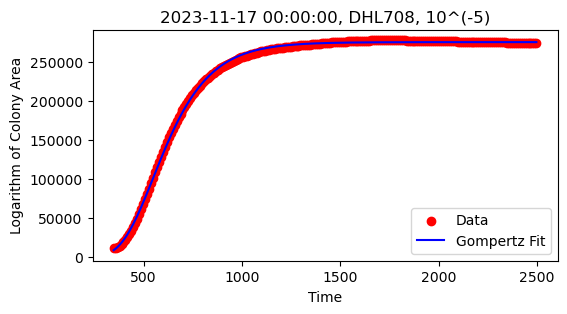

Fitted parameters [A, mu_m, lambda]: [274902.57651576    629.56308413    387.60286248], i: 13


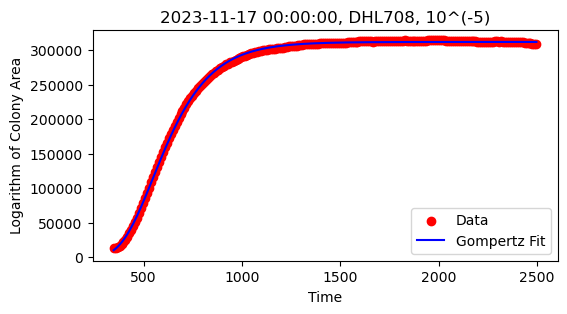

Fitted parameters [A, mu_m, lambda]: [312159.93849304    706.64245699    384.71067026], i: 14


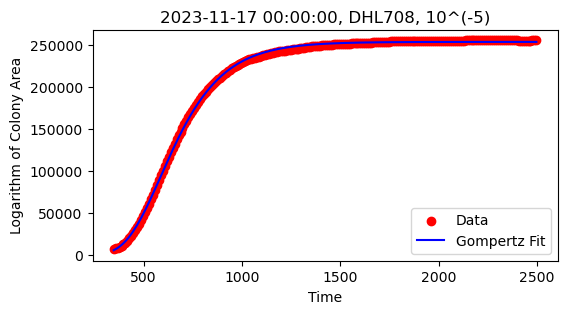

Fitted parameters [A, mu_m, lambda]: [254143.48555508    529.60084757    409.78002171], i: 15


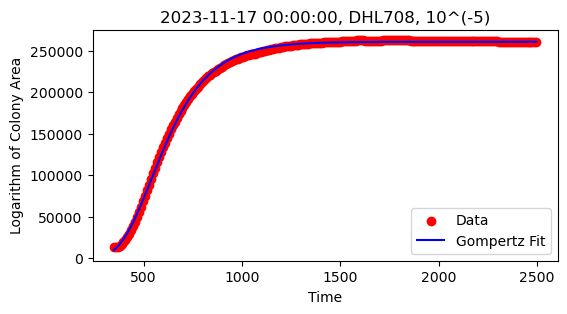

Fitted parameters [A, mu_m, lambda]: [260740.32635104    594.85161229    379.05476356], i: 16


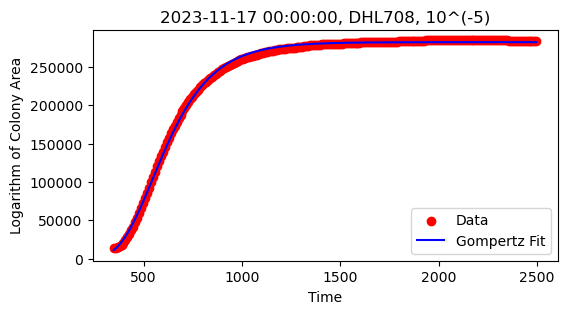

Fitted parameters [A, mu_m, lambda]: [282402.84589936    619.01435533    377.44220516], i: 17


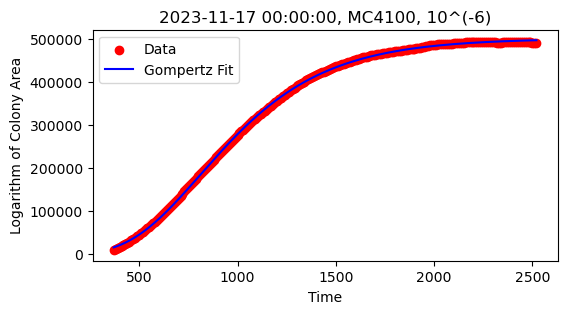

Fitted parameters [A, mu_m, lambda]: [5.00847258e+05 5.18636084e+02 4.55038350e+02], i: 18


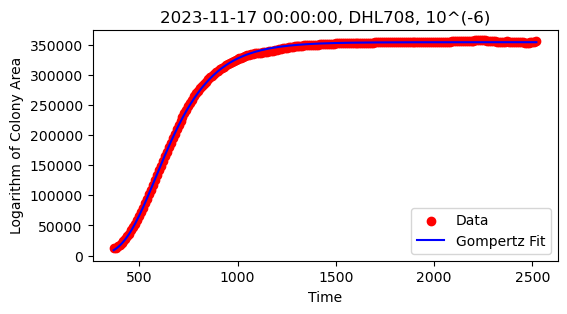

Fitted parameters [A, mu_m, lambda]: [354022.27956823    793.05414458    420.35181783], i: 19


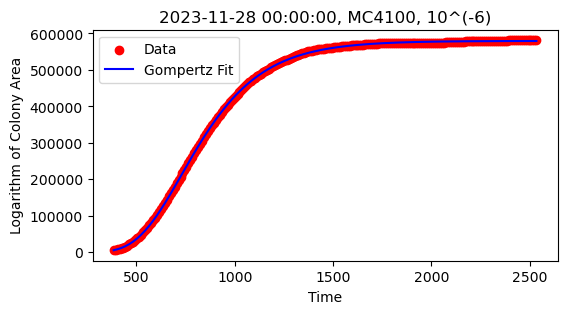

Fitted parameters [A, mu_m, lambda]: [5.79569277e+05 9.41612800e+02 5.03552726e+02], i: 20


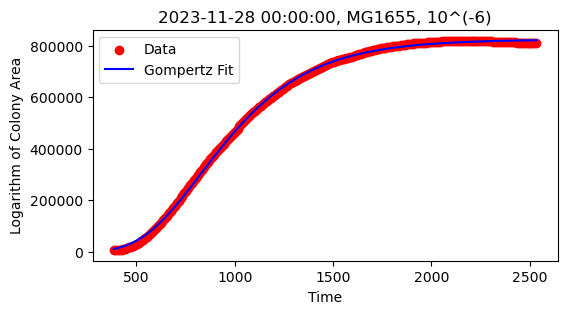

Fitted parameters [A, mu_m, lambda]: [8.24347497e+05 9.97429661e+02 5.23615951e+02], i: 21


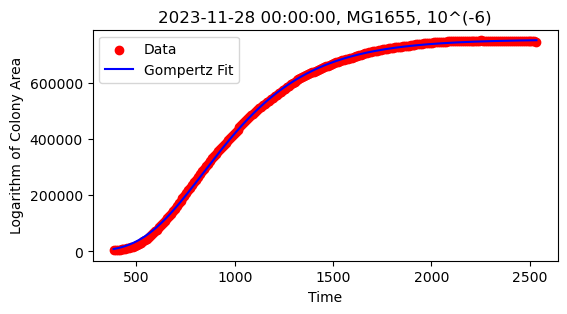

Fitted parameters [A, mu_m, lambda]: [7.55948412e+05 9.15661760e+02 5.33813188e+02], i: 22


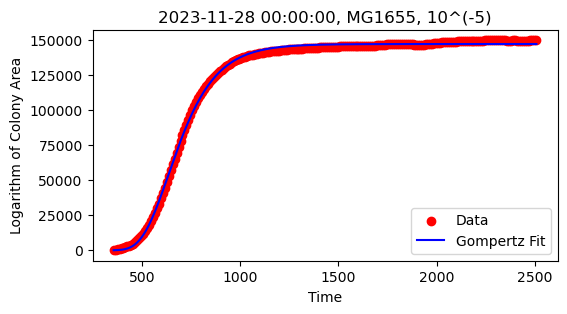

Fitted parameters [A, mu_m, lambda]: [147371.23600568    402.72761854    501.50963683], i: 23


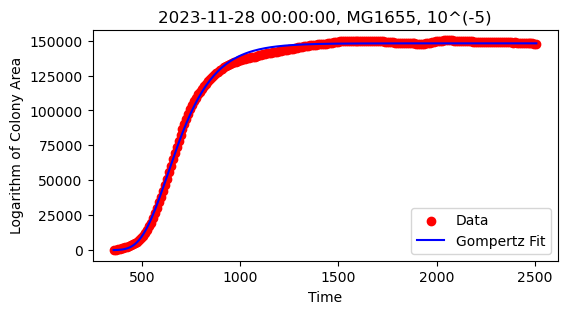

Fitted parameters [A, mu_m, lambda]: [148046.75976482    411.97330285    499.72318332], i: 24


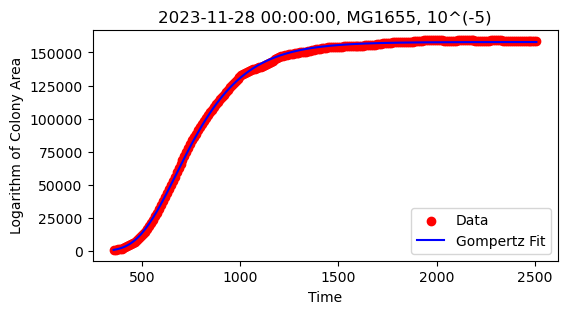

Fitted parameters [A, mu_m, lambda]: [157851.99644261    298.27147499    480.57416469], i: 25


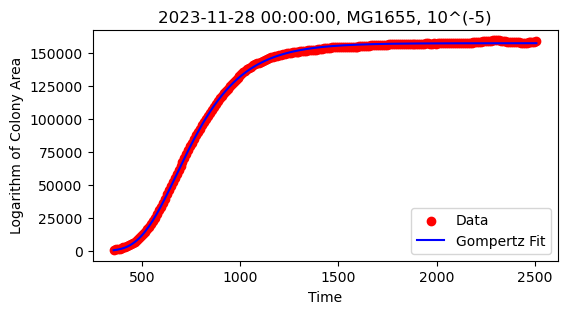

Fitted parameters [A, mu_m, lambda]: [157087.51080459    311.35901984    491.37036054], i: 26


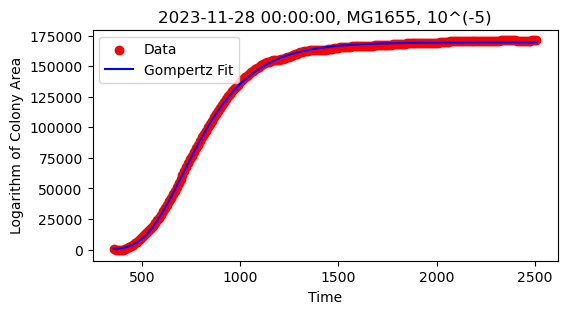

Fitted parameters [A, mu_m, lambda]: [169498.72641599    321.2339823     515.76441295], i: 27


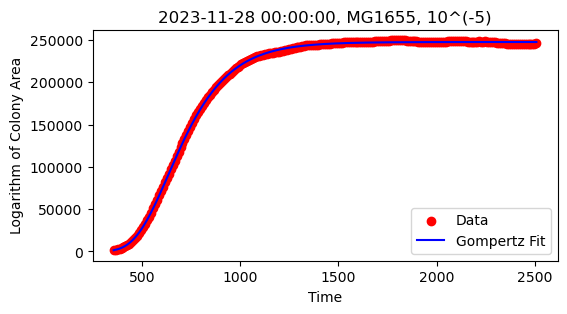

Fitted parameters [A, mu_m, lambda]: [247583.96354594    533.76350829    465.11502266], i: 28


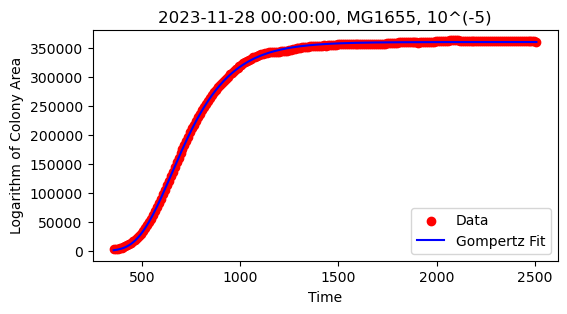

Fitted parameters [A, mu_m, lambda]: [359595.23483819    785.95708786    482.70346914], i: 29


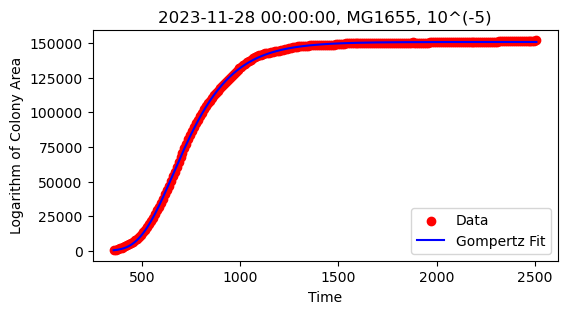

Fitted parameters [A, mu_m, lambda]: [150777.99204374    328.52669722    491.07911738], i: 30


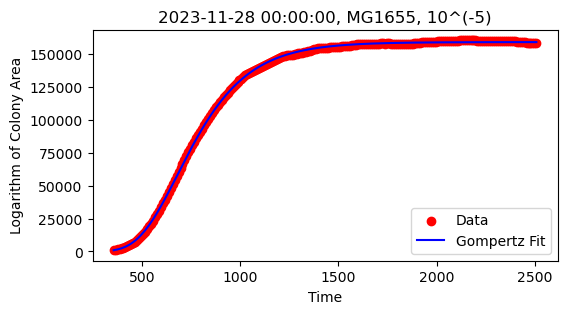

Fitted parameters [A, mu_m, lambda]: [158729.77432023    292.89240383    483.01714104], i: 31


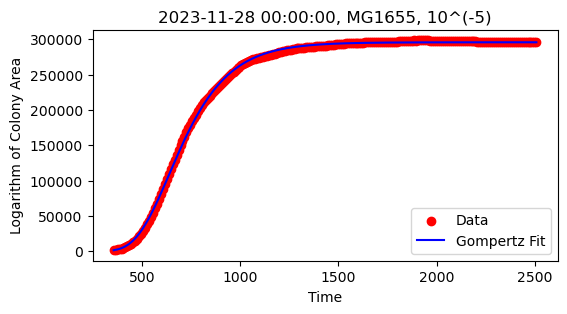

Fitted parameters [A, mu_m, lambda]: [295604.98274708    645.42072709    470.83115797], i: 32


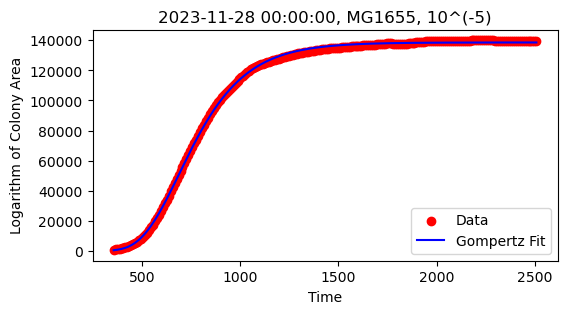

Fitted parameters [A, mu_m, lambda]: [138582.53698352    269.16218322    499.86089404], i: 33


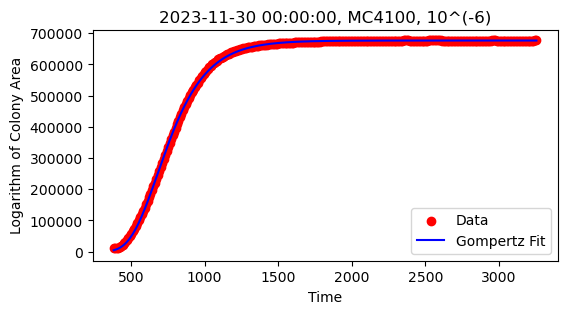

Fitted parameters [A, mu_m, lambda]: [6.76733580e+05 1.34811603e+03 4.95967587e+02], i: 34


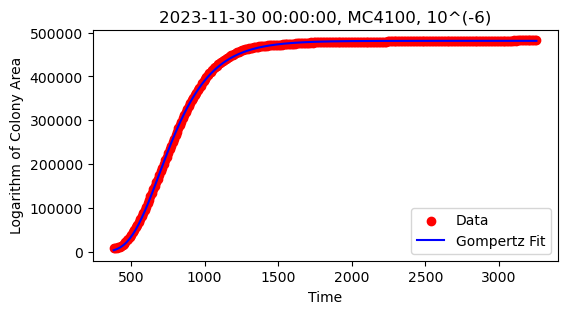

Fitted parameters [A, mu_m, lambda]: [481302.13218501    898.51965476    495.09786432], i: 35


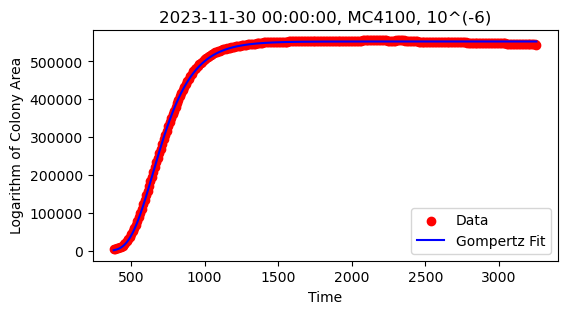

Fitted parameters [A, mu_m, lambda]: [5.52797433e+05 1.33500802e+03 4.95898961e+02], i: 36


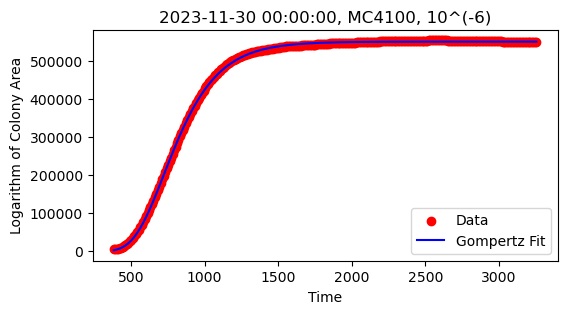

Fitted parameters [A, mu_m, lambda]: [5.51833916e+05 9.90279071e+02 5.20191564e+02], i: 37


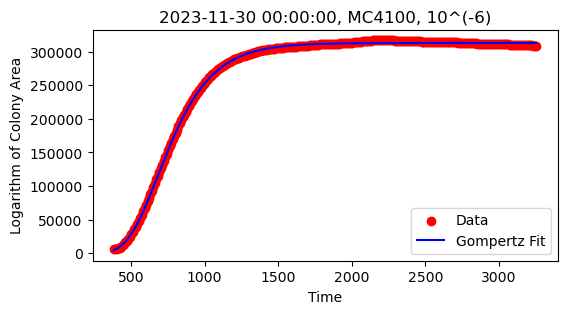

Fitted parameters [A, mu_m, lambda]: [313158.16321435    558.96415468    476.56509017], i: 38


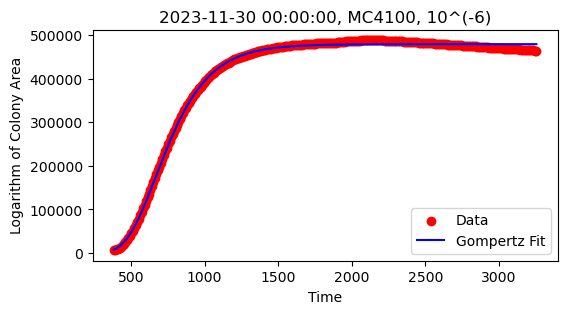

Fitted parameters [A, mu_m, lambda]: [4.79405219e+05 8.76908085e+02 4.69049725e+02], i: 39


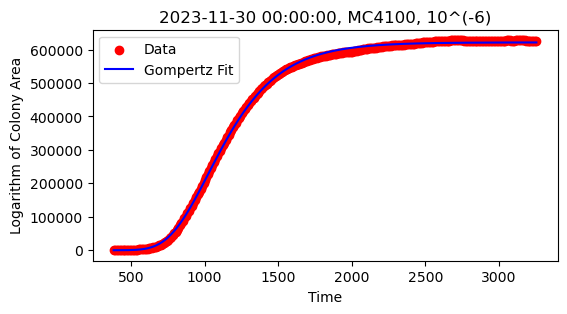

Fitted parameters [A, mu_m, lambda]: [621311.98604973    854.32404735    758.32644801], i: 40


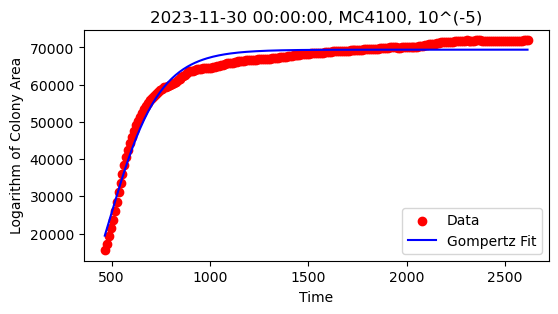

Fitted parameters [A, mu_m, lambda]: [69399.38922834   177.8707832    356.10919354], i: 41


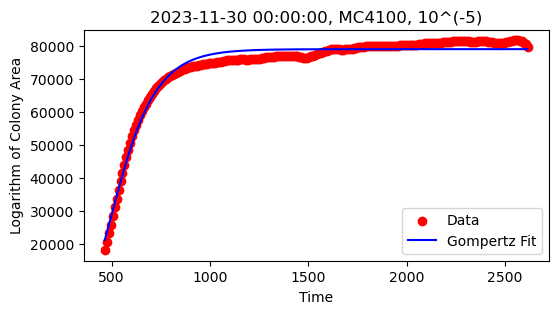

Fitted parameters [A, mu_m, lambda]: [79053.02133773   224.56695758   371.57362659], i: 42


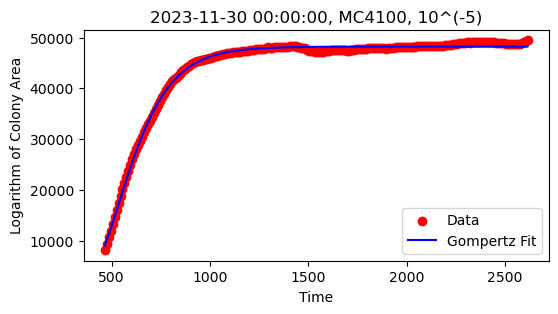

Fitted parameters [A, mu_m, lambda]: [48229.51569763   122.07888242   394.33565946], i: 43


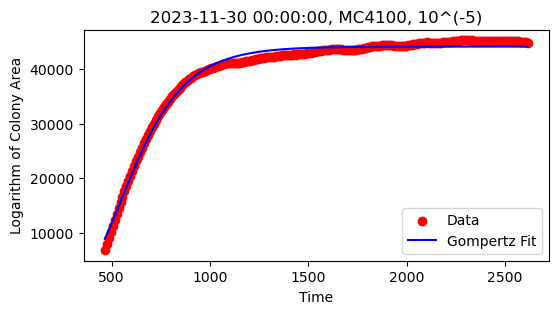

Fitted parameters [A, mu_m, lambda]: [44106.05216209    88.69161094   367.70520817], i: 44


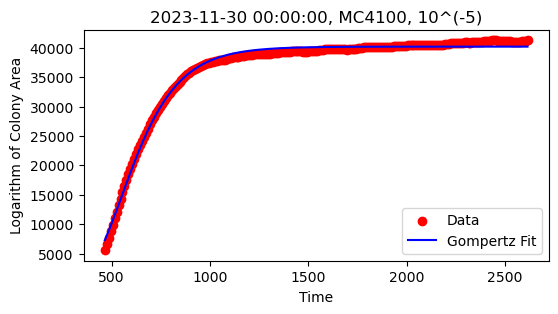

Fitted parameters [A, mu_m, lambda]: [40211.06485164    91.93205615   390.50280474], i: 45


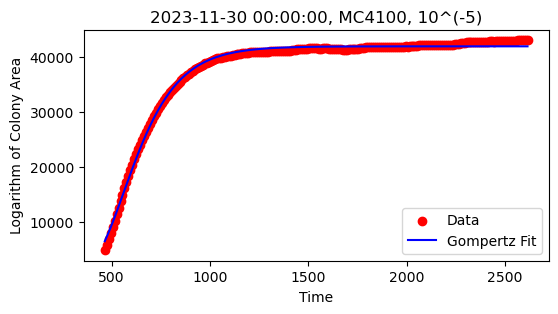

Fitted parameters [A, mu_m, lambda]: [41969.99579892    99.72862333   407.39438332], i: 46


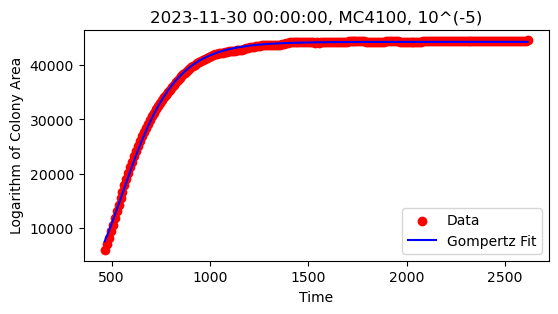

Fitted parameters [A, mu_m, lambda]: [44308.00960889   104.28860043   397.7597791 ], i: 47


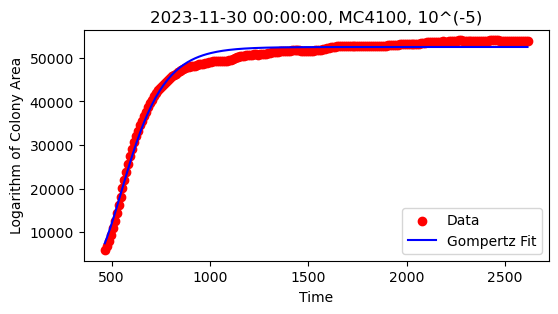

Fitted parameters [A, mu_m, lambda]: [52488.47553742   153.48249881   423.50094697], i: 48


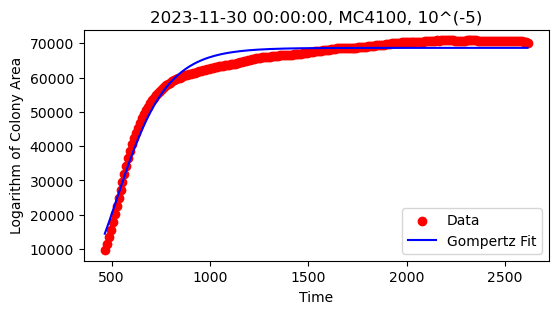

Fitted parameters [A, mu_m, lambda]: [68643.79684263   172.48129675   383.22172167], i: 49


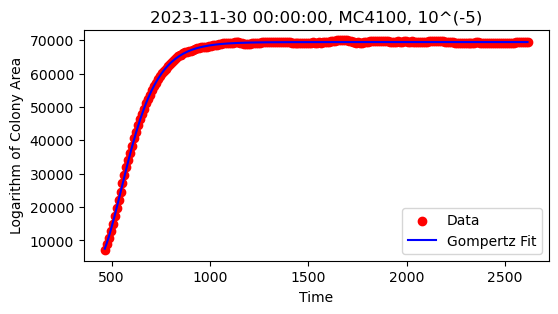

Fitted parameters [A, mu_m, lambda]: [69433.85048866   241.2536289    443.76753957], i: 50


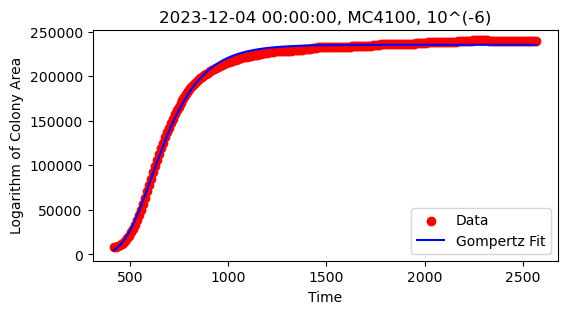

Fitted parameters [A, mu_m, lambda]: [235339.61872855    611.93968169    469.0661719 ], i: 51


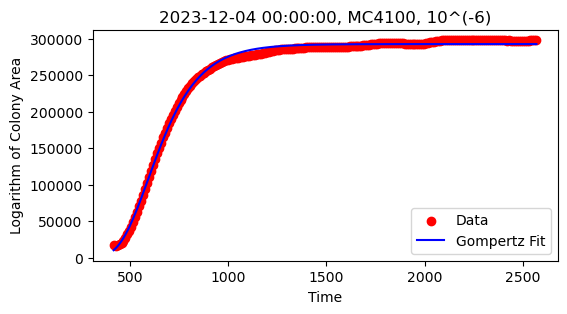

Fitted parameters [A, mu_m, lambda]: [292624.69262109    741.92085551    448.74773084], i: 52


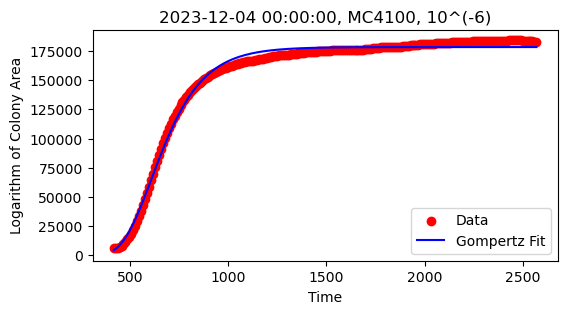

Fitted parameters [A, mu_m, lambda]: [178370.55570029    447.38700308    464.05711255], i: 53


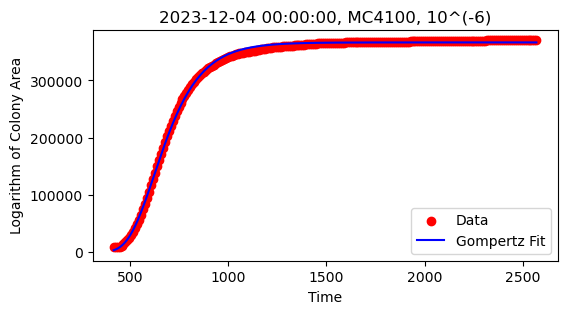

Fitted parameters [A, mu_m, lambda]: [366574.84691241   1021.05939913    492.12742724], i: 54


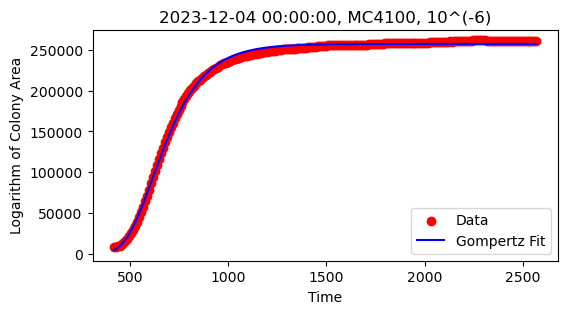

Fitted parameters [A, mu_m, lambda]: [257488.78184401    663.86120395    476.52469276], i: 55


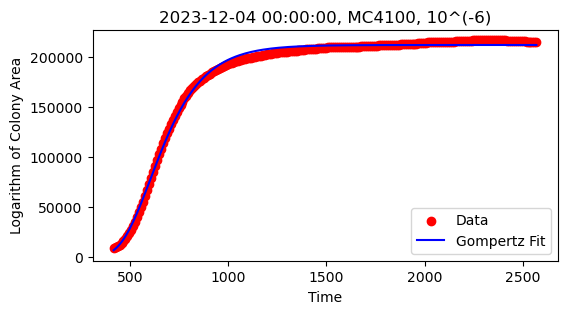

Fitted parameters [A, mu_m, lambda]: [211709.70046796    517.25914772    454.86326614], i: 56


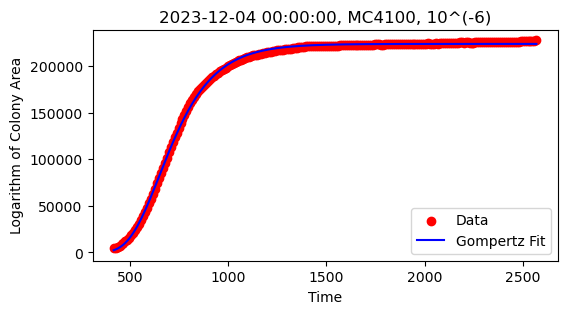

Fitted parameters [A, mu_m, lambda]: [223978.24834284    535.18676963    496.22850608], i: 57


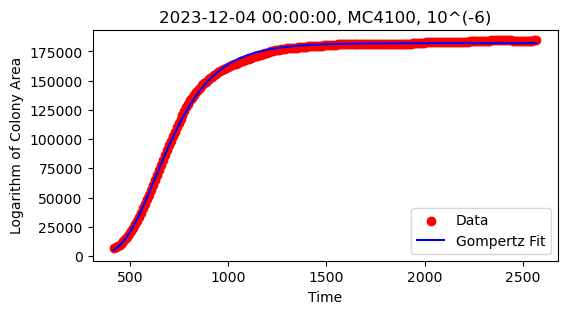

Fitted parameters [A, mu_m, lambda]: [182151.25916695    406.24709002    464.90886965], i: 58


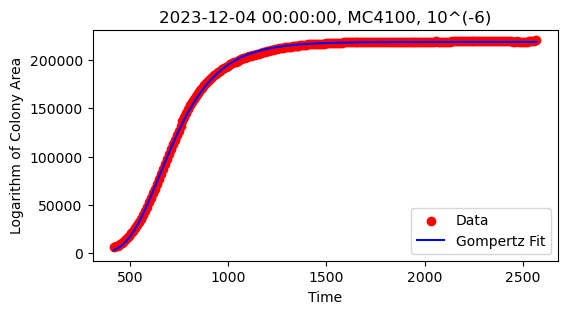

Fitted parameters [A, mu_m, lambda]: [218560.7182646     499.36334222    489.94144581], i: 59


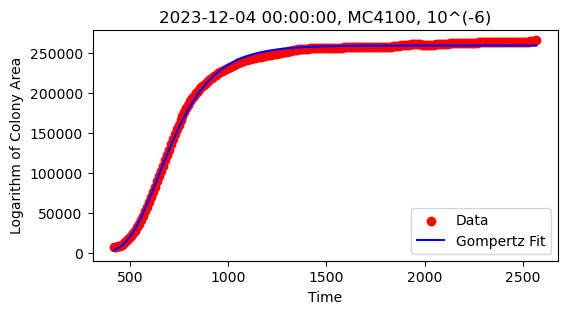

Fitted parameters [A, mu_m, lambda]: [259652.69815626    623.87518338    491.79138995], i: 60


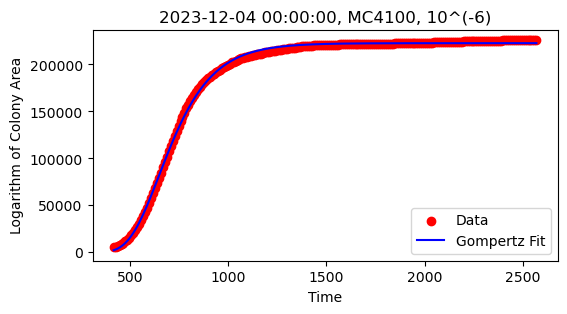

Fitted parameters [A, mu_m, lambda]: [222706.1019213     540.87687967    497.57268507], i: 61


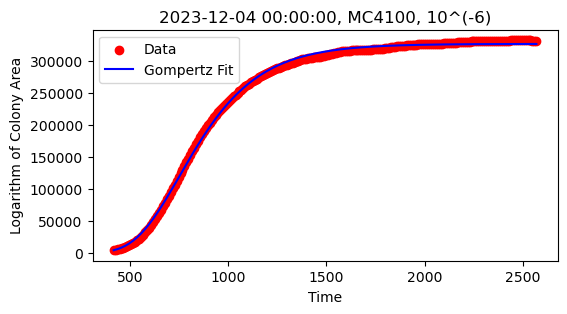

Fitted parameters [A, mu_m, lambda]: [326662.72017901    533.34407453    528.06981715], i: 62


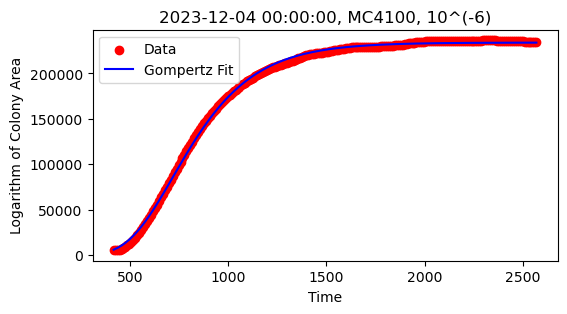

Fitted parameters [A, mu_m, lambda]: [234099.46454853    374.46331074    490.22824812], i: 63


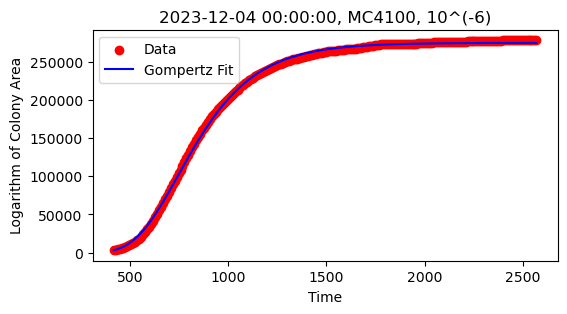

Fitted parameters [A, mu_m, lambda]: [274691.68189854    462.61157783    527.05143445], i: 64


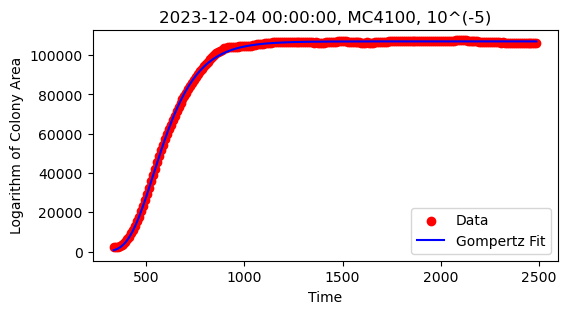

Fitted parameters [A, mu_m, lambda]: [106990.96863126    315.03894192    413.50158472], i: 65


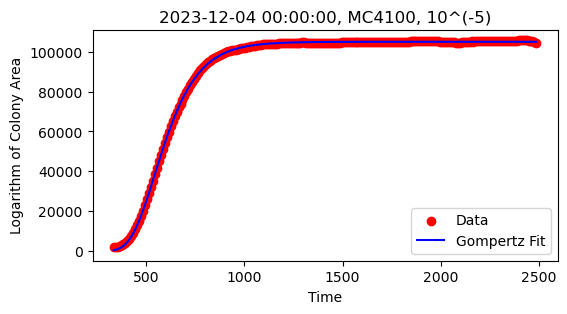

Fitted parameters [A, mu_m, lambda]: [104944.1305173     315.63446838    423.42007763], i: 66


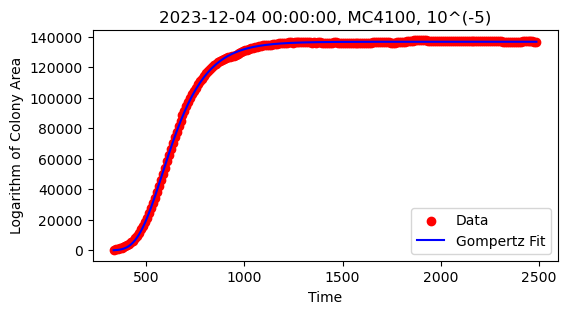

Fitted parameters [A, mu_m, lambda]: [136742.76333662    399.85973854    458.01822208], i: 67


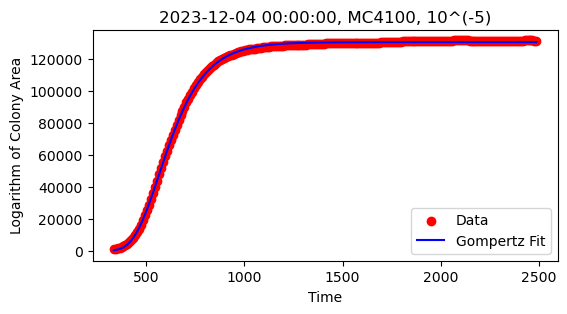

Fitted parameters [A, mu_m, lambda]: [130448.2042232     370.6753524     438.23337224], i: 68


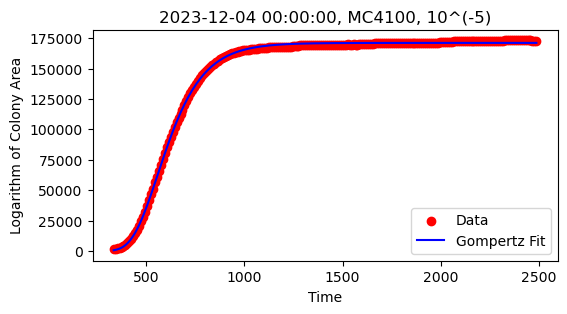

Fitted parameters [A, mu_m, lambda]: [171065.22114374    486.62625168    431.03603128], i: 69


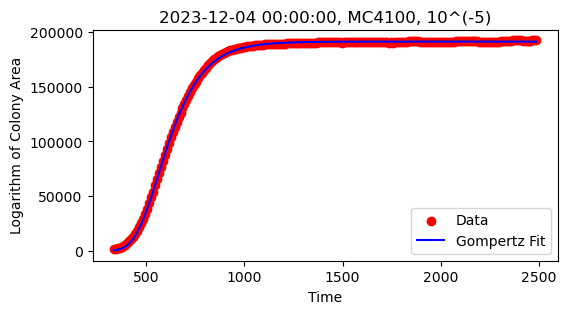

Fitted parameters [A, mu_m, lambda]: [191453.77540687    573.29768828    441.7414662 ], i: 70


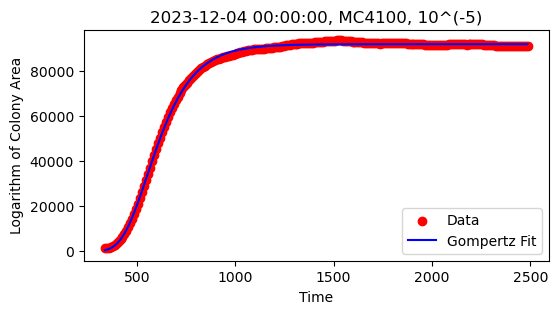

Fitted parameters [A, mu_m, lambda]: [91860.56077221   260.37030636   422.6571332 ], i: 71


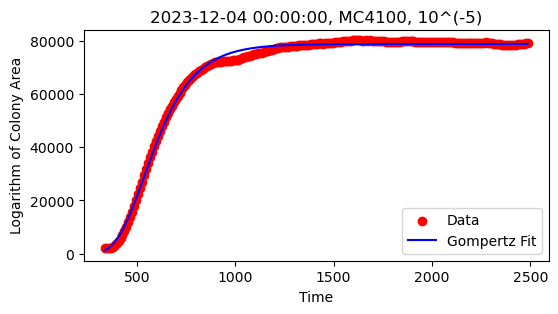

Fitted parameters [A, mu_m, lambda]: [78851.97389838   205.64425873   395.19478276], i: 72


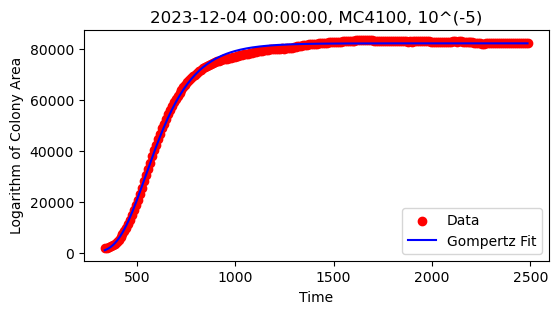

Fitted parameters [A, mu_m, lambda]: [82059.47342218   218.20415345   405.71386695], i: 73


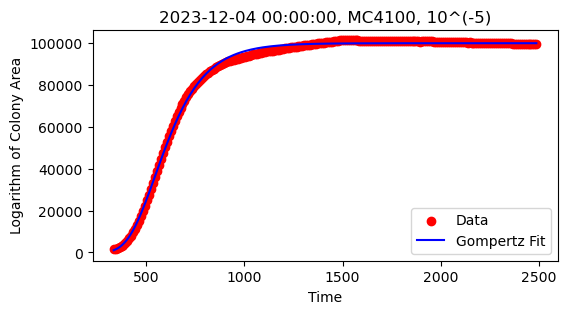

Fitted parameters [A, mu_m, lambda]: [99760.32020774   262.12770988   407.70549986], i: 74


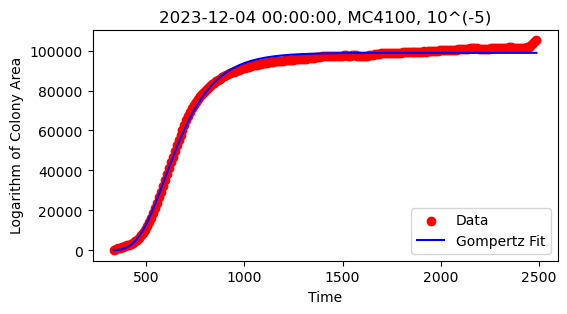

Fitted parameters [A, mu_m, lambda]: [98831.83977665   264.69141833   460.51463983], i: 75


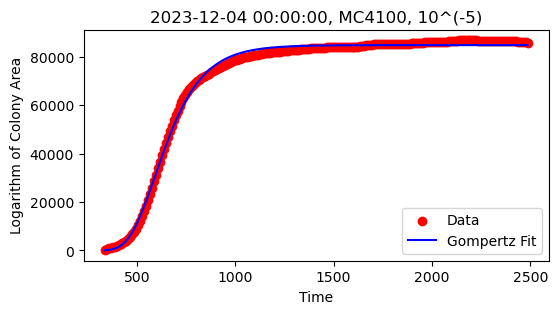

Fitted parameters [A, mu_m, lambda]: [84910.20125932   234.05403878   460.00225783], i: 76


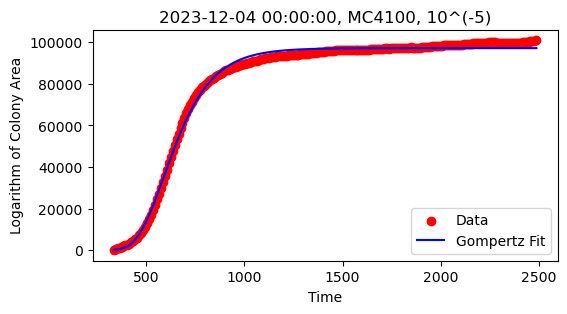

Fitted parameters [A, mu_m, lambda]: [97225.85252533   262.47776006   456.45945845], i: 77


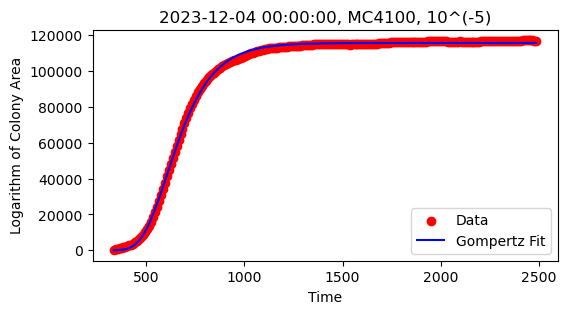

Fitted parameters [A, mu_m, lambda]: [115722.10054215    331.95301672    480.11993801], i: 78


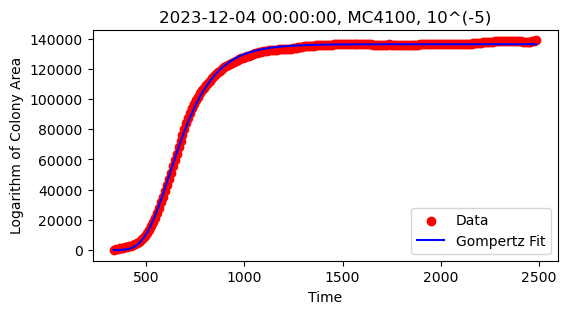

Fitted parameters [A, mu_m, lambda]: [136305.3229671     395.97344356    493.53685294], i: 79


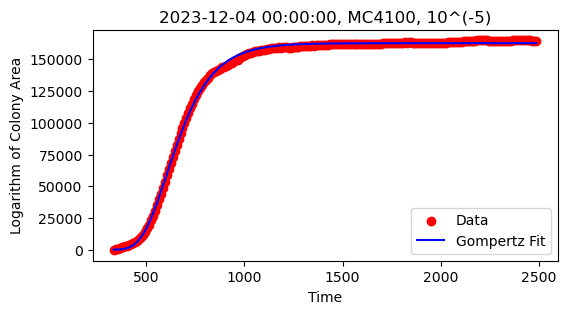

Fitted parameters [A, mu_m, lambda]: [162788.68841781    466.8313577     478.73530295], i: 80


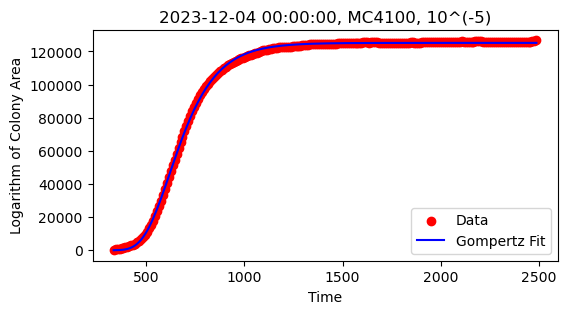

Fitted parameters [A, mu_m, lambda]: [125138.62979841    347.1477245     487.61112106], i: 81


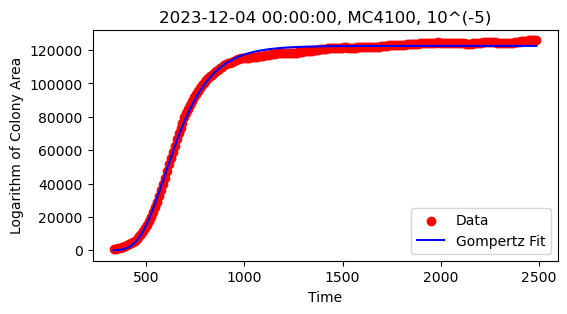

Fitted parameters [A, mu_m, lambda]: [122463.58119061    350.53455586    467.91301634], i: 82


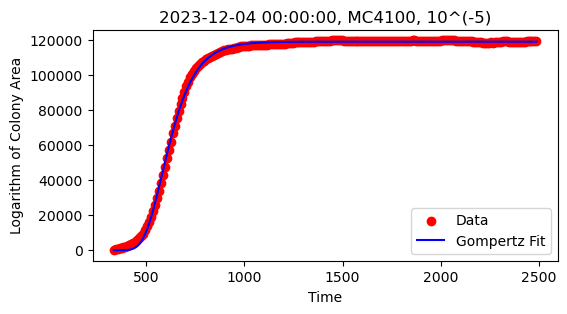

Fitted parameters [A, mu_m, lambda]: [118865.86651151    470.52153184    490.15948159], i: 83


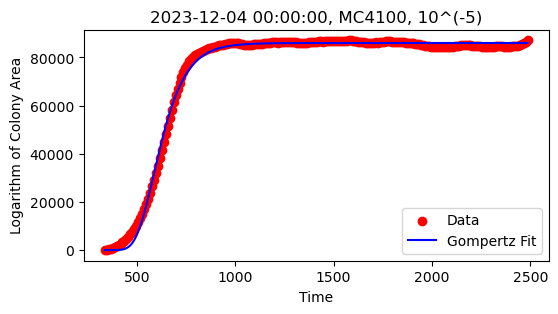

Fitted parameters [A, mu_m, lambda]: [86018.88761724   350.25440867   495.37525017], i: 84


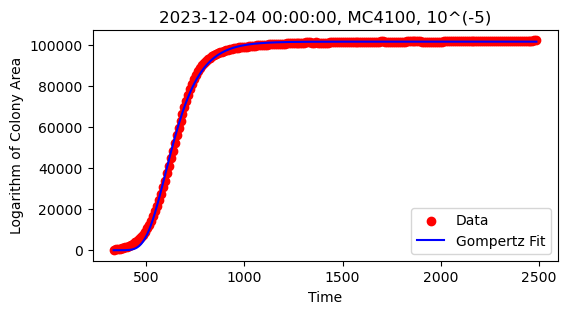

Fitted parameters [A, mu_m, lambda]: [101500.22734403    379.85371619    500.98926158], i: 85


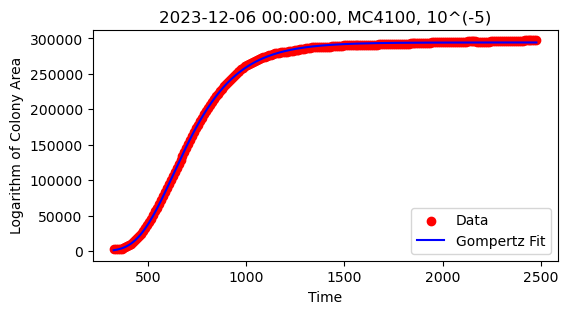

Fitted parameters [A, mu_m, lambda]: [294256.797776      603.41783474    450.02857312], i: 86


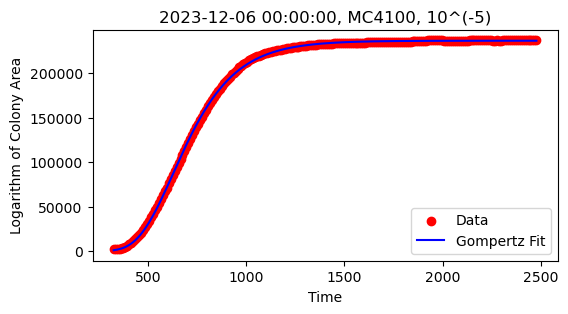

Fitted parameters [A, mu_m, lambda]: [236321.75708991    492.0000098     451.32692767], i: 87


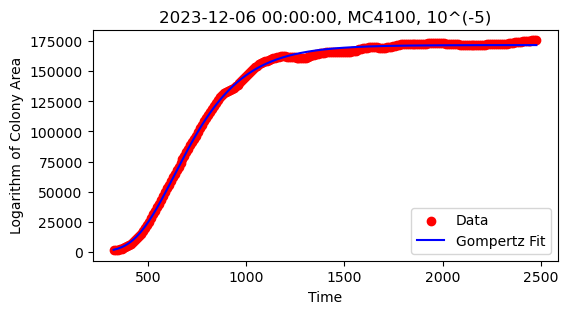

Fitted parameters [A, mu_m, lambda]: [171903.27123127    318.67945028    434.91502581], i: 88


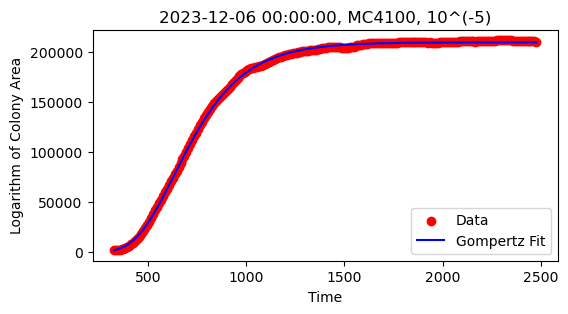

Fitted parameters [A, mu_m, lambda]: [209588.54984692    391.86830306    437.39873346], i: 89


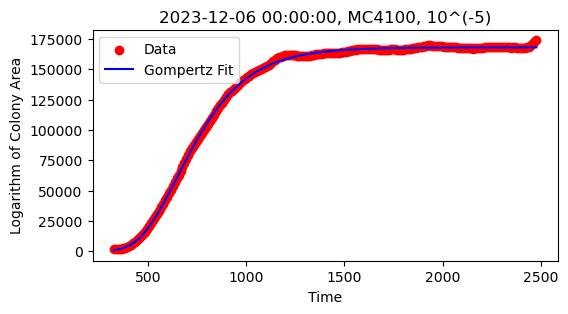

Fitted parameters [A, mu_m, lambda]: [168033.57087705    318.28628341    457.60326909], i: 90


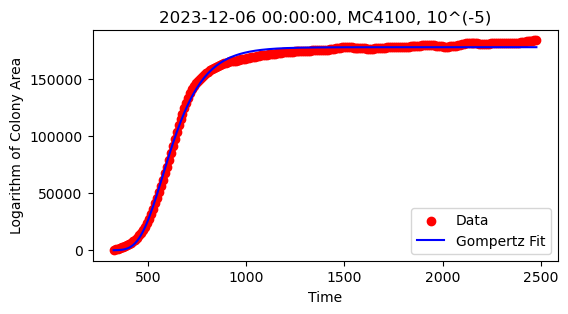

Fitted parameters [A, mu_m, lambda]: [177638.23833304    563.06467658    459.75337351], i: 91


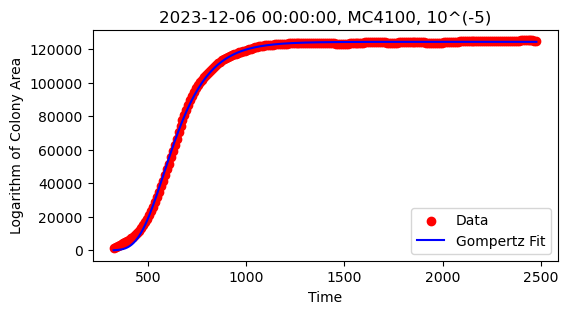

Fitted parameters [A, mu_m, lambda]: [124389.24394828    358.30751426    453.26567729], i: 92


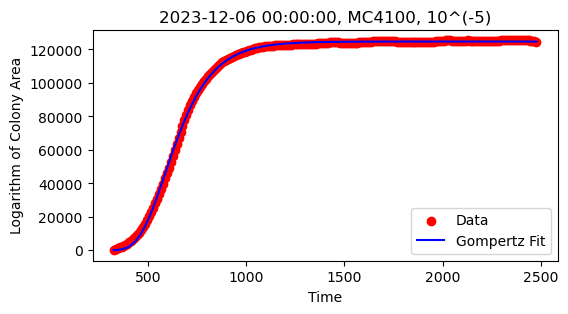

Fitted parameters [A, mu_m, lambda]: [124711.99191851    346.04792139    455.20679497], i: 93


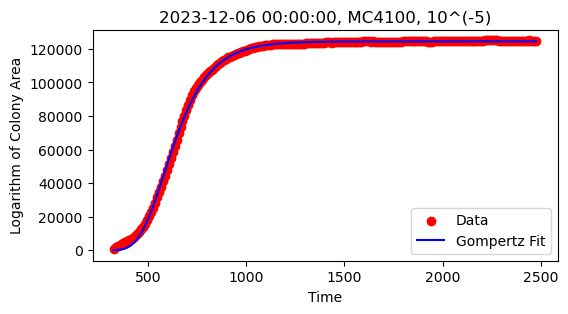

Fitted parameters [A, mu_m, lambda]: [124437.12020102    357.25503562    454.72410383], i: 94


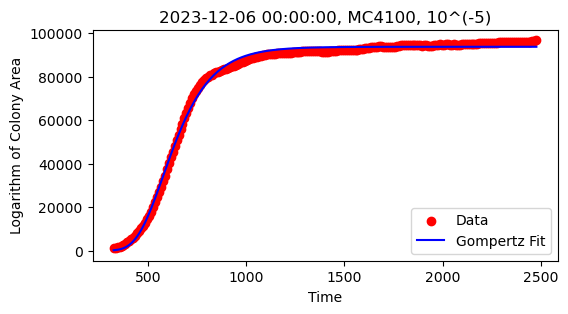

Fitted parameters [A, mu_m, lambda]: [93792.3346624    254.70285057   442.86965256], i: 95


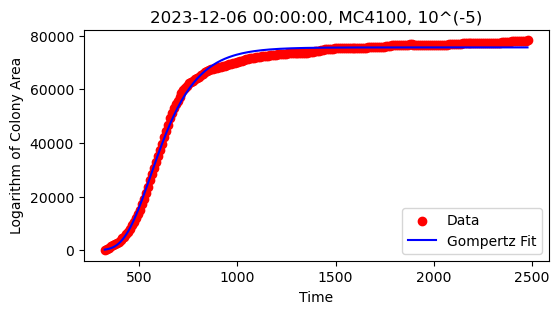

Fitted parameters [A, mu_m, lambda]: [75570.44803397   210.09151626   426.80286671], i: 96


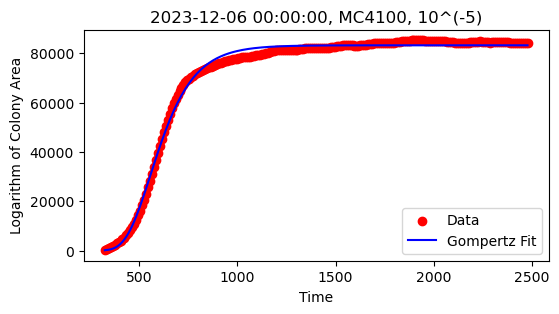

Fitted parameters [A, mu_m, lambda]: [83191.4032956    247.16720135   434.42631591], i: 97


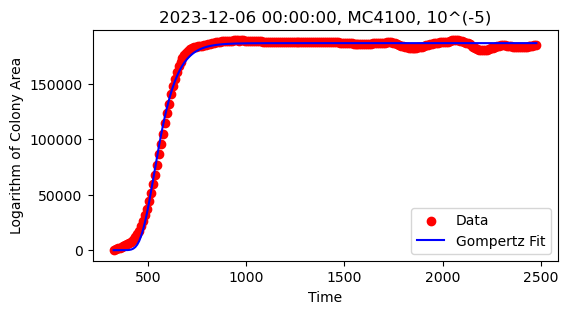

Fitted parameters [A, mu_m, lambda]: [186349.44741973   1029.71690242    464.91114134], i: 98


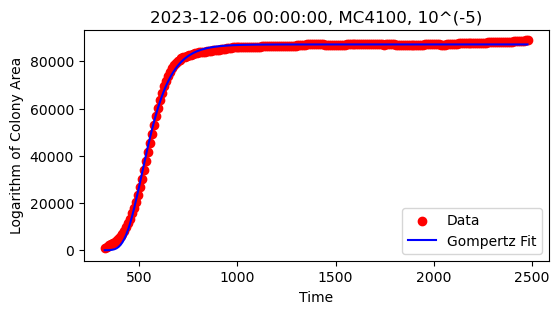

Fitted parameters [A, mu_m, lambda]: [87158.18597874   386.24358302   430.74510212], i: 99


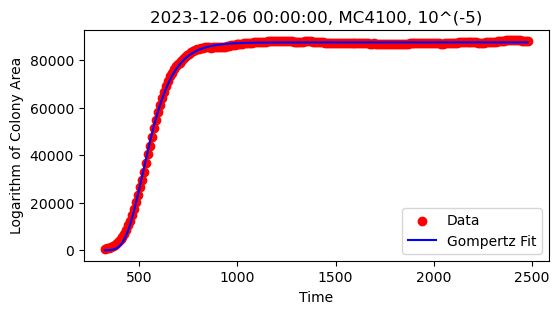

Fitted parameters [A, mu_m, lambda]: [87418.28608125   372.91699187   432.0908873 ], i: 100


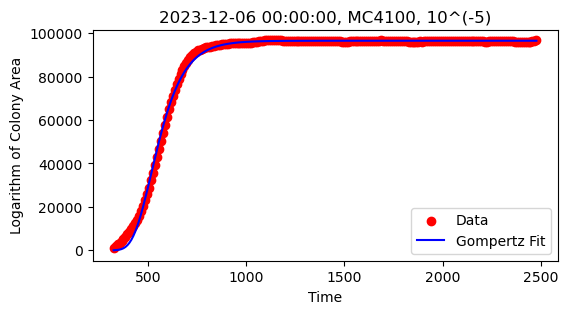

Fitted parameters [A, mu_m, lambda]: [96551.47542329   384.07619854   424.85268373], i: 101


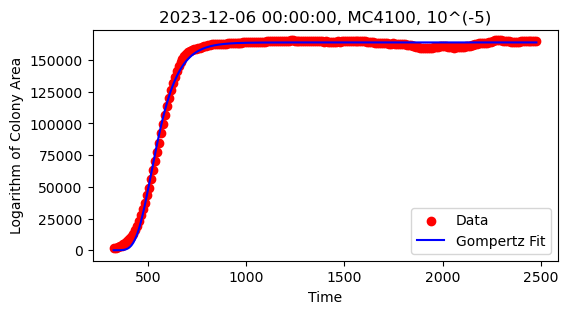

Fitted parameters [A, mu_m, lambda]: [163971.28955995    798.56128183    440.97094536], i: 102


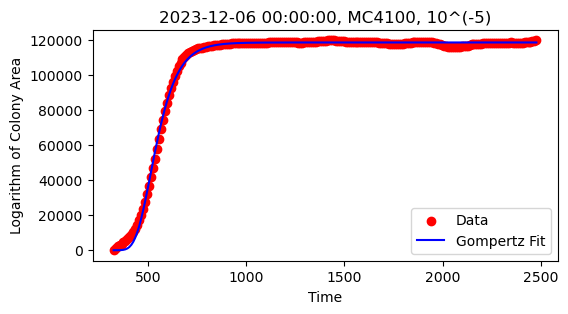

Fitted parameters [A, mu_m, lambda]: [118540.86321143    575.27537404    438.17945405], i: 103


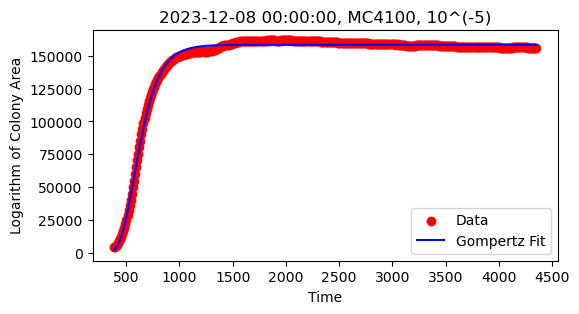

Fitted parameters [A, mu_m, lambda]: [158491.37438578    451.100699      445.91609305], i: 104


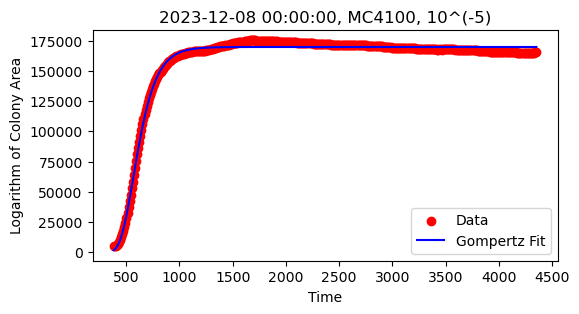

Fitted parameters [A, mu_m, lambda]: [169793.45873385    518.60751348    447.06498147], i: 105


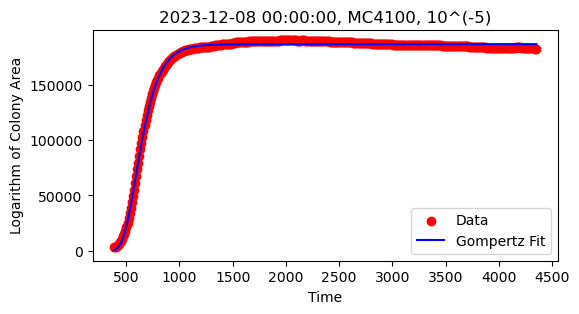

Fitted parameters [A, mu_m, lambda]: [186430.31049501    567.71734852    471.28709735], i: 106


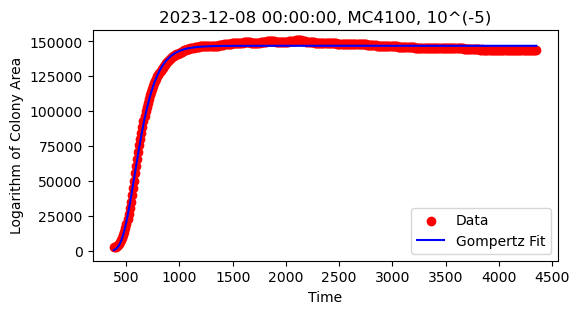

Fitted parameters [A, mu_m, lambda]: [146877.84730965    470.53253614    463.26270679], i: 107


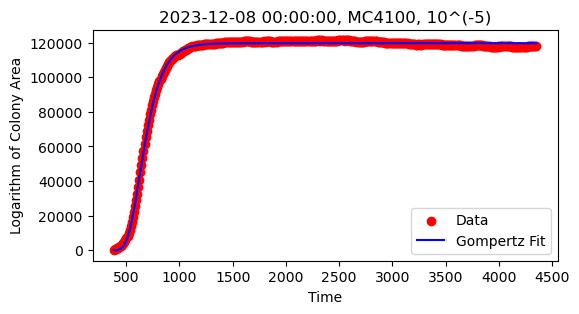

Fitted parameters [A, mu_m, lambda]: [119672.33646545    383.01924274    513.07903647], i: 108


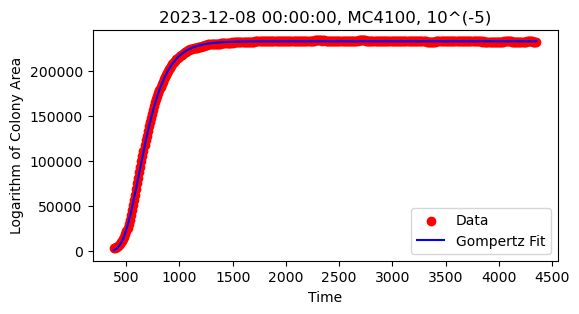

Fitted parameters [A, mu_m, lambda]: [232758.78286467    593.95269201    475.33275307], i: 109


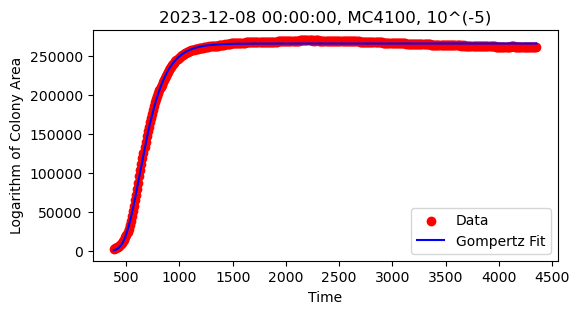

Fitted parameters [A, mu_m, lambda]: [266093.50632751    721.95912102    490.26136806], i: 110


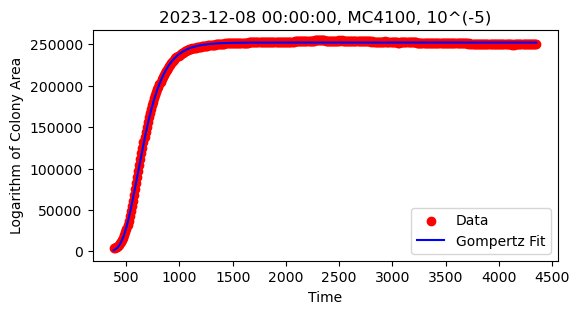

Fitted parameters [A, mu_m, lambda]: [252056.33202248    680.99743651    470.04521261], i: 111


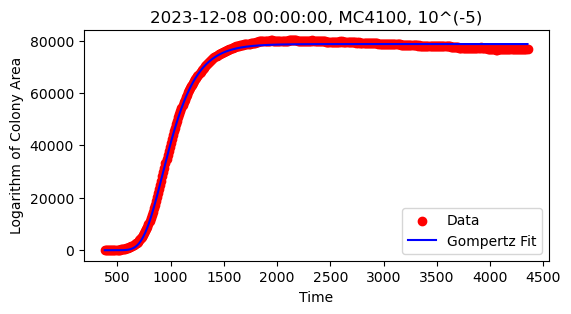

Fitted parameters [A, mu_m, lambda]: [78651.99703222   160.33817479   743.8861657 ], i: 112


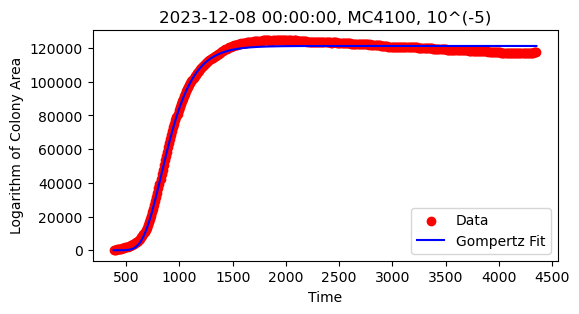

Fitted parameters [A, mu_m, lambda]: [121235.60293333    265.28993311    660.1886112 ], i: 113


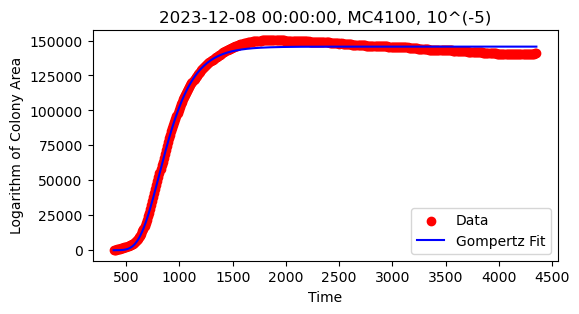

Fitted parameters [A, mu_m, lambda]: [145649.29645343    294.37699388    626.4739347 ], i: 114


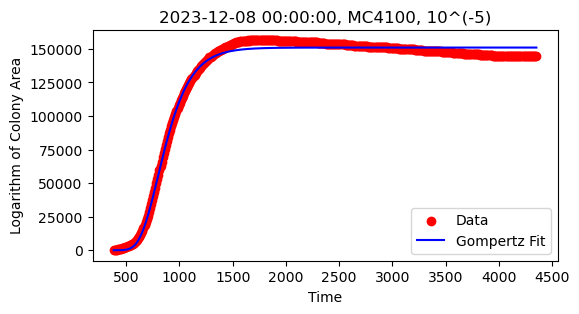

Fitted parameters [A, mu_m, lambda]: [150959.18156232    328.08002305    630.56022739], i: 115


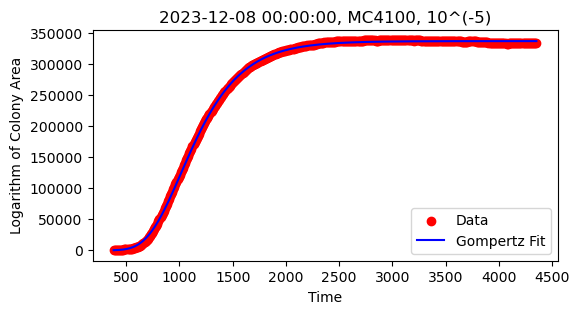

Fitted parameters [A, mu_m, lambda]: [336187.0416832     392.33331357    698.89403113], i: 116


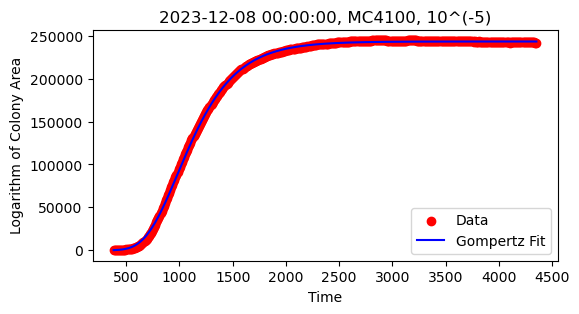

Fitted parameters [A, mu_m, lambda]: [243210.79111892    294.48178216    680.84342264], i: 117


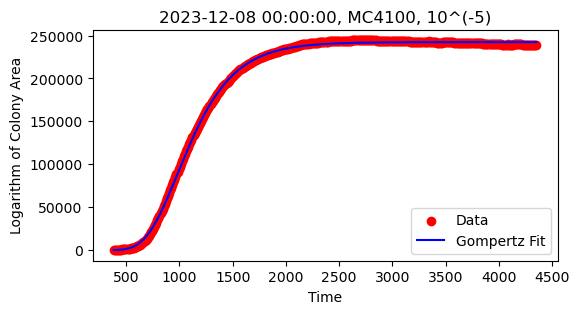

Fitted parameters [A, mu_m, lambda]: [242333.37720907    302.33436728    687.52829057], i: 118


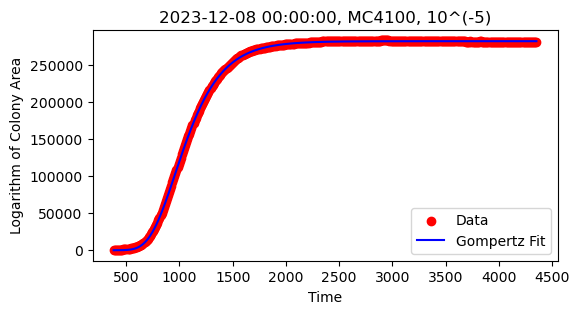

Fitted parameters [A, mu_m, lambda]: [281678.96217542    430.00226651    720.30640878], i: 119


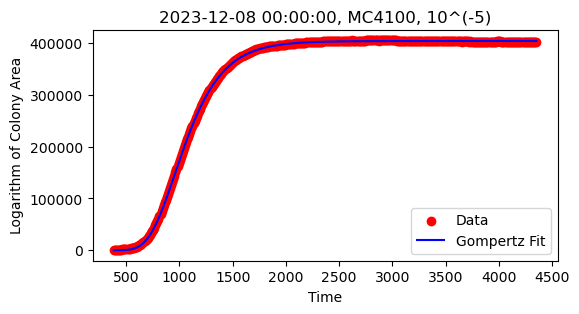

Fitted parameters [A, mu_m, lambda]: [403796.17851641    605.07464491    713.26611221], i: 120


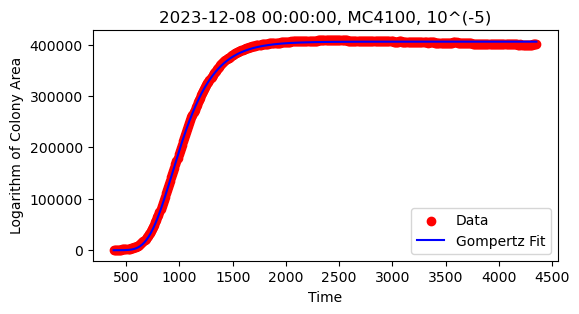

Fitted parameters [A, mu_m, lambda]: [405637.65684632    679.64859955    711.93482909], i: 121


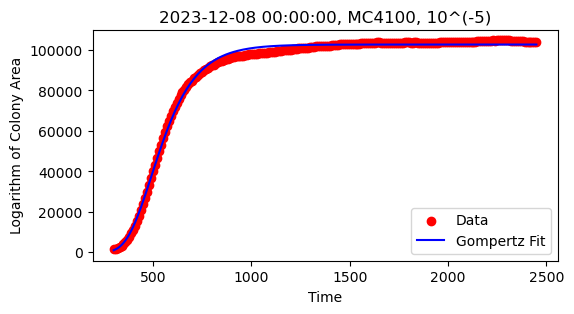

Fitted parameters [A, mu_m, lambda]: [102725.28158502    300.04738174    365.33627343], i: 122


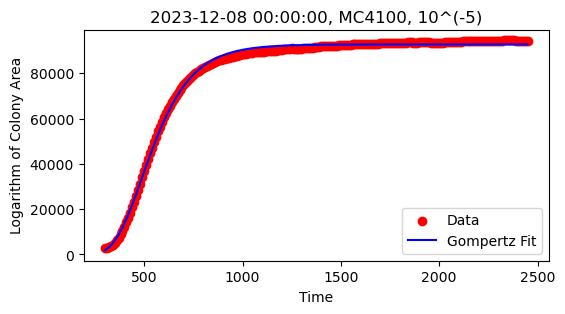

Fitted parameters [A, mu_m, lambda]: [92787.23435713   244.2487523    349.57307988], i: 123


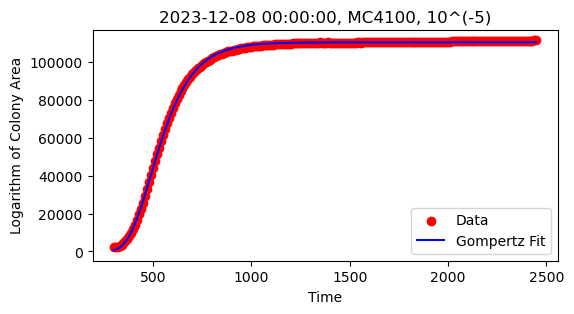

Fitted parameters [A, mu_m, lambda]: [110169.53599354    347.66208921    372.63640718], i: 124


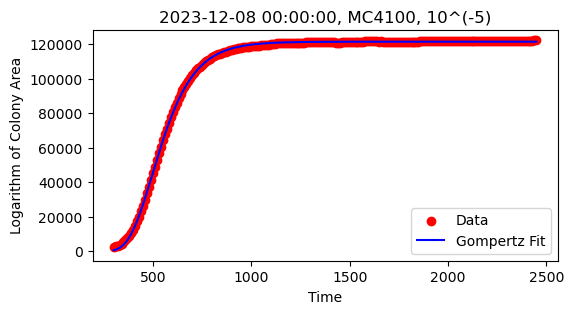

Fitted parameters [A, mu_m, lambda]: [121431.26694607    378.15028197    377.88463615], i: 125


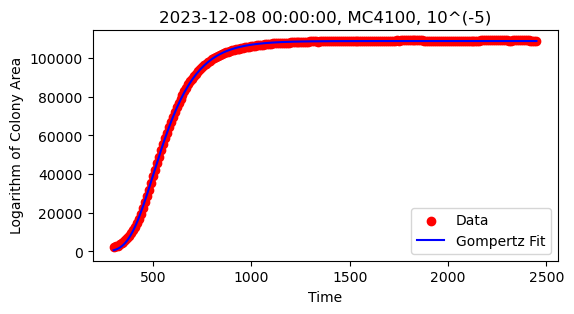

Fitted parameters [A, mu_m, lambda]: [108865.37047531    324.95870298    378.25979876], i: 126


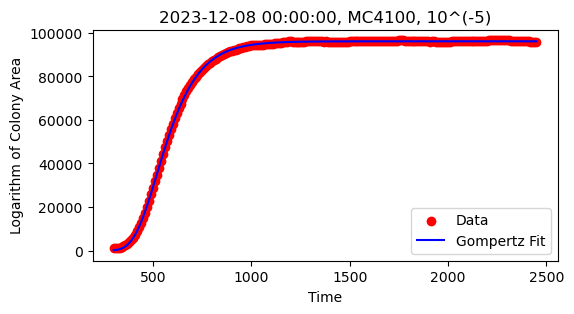

Fitted parameters [A, mu_m, lambda]: [96137.17492645   300.19185032   401.89219613], i: 127


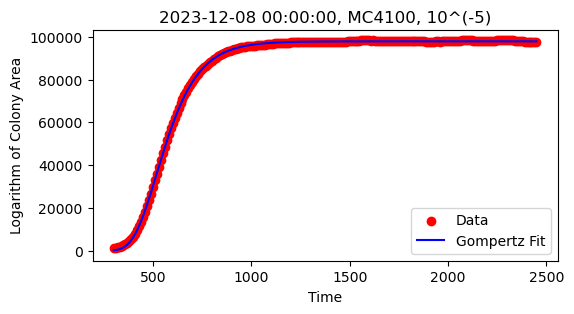

Fitted parameters [A, mu_m, lambda]: [97901.86455215   304.62378821   399.70879568], i: 128


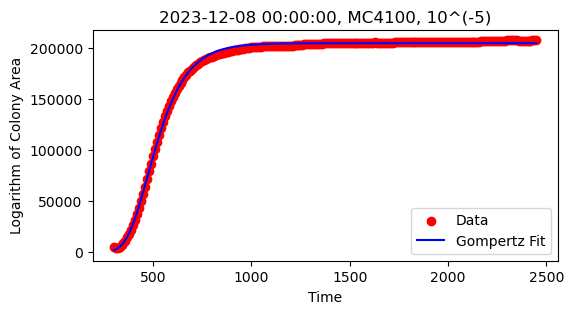

Fitted parameters [A, mu_m, lambda]: [204275.13176787    692.68734996    364.94661167], i: 129


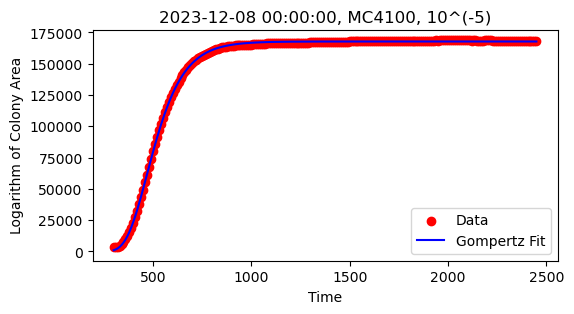

Fitted parameters [A, mu_m, lambda]: [167736.93852011    594.19369839    364.88827355], i: 130


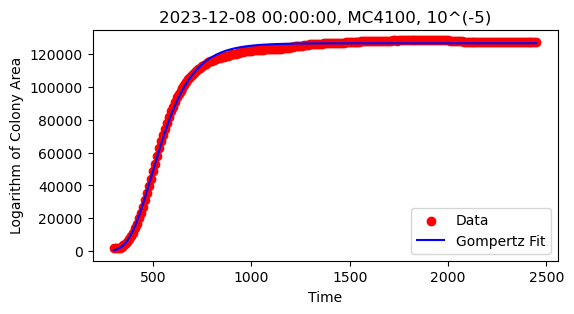

Fitted parameters [A, mu_m, lambda]: [126658.78987489    408.80153648    379.18372494], i: 131


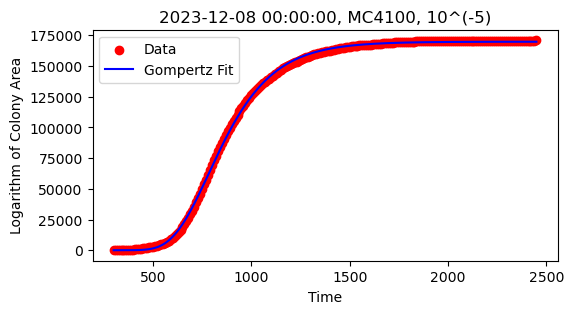

Fitted parameters [A, mu_m, lambda]: [169799.03795325    342.98416847    600.57461166], i: 132


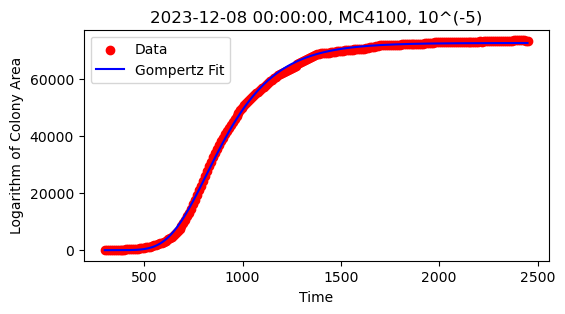

Fitted parameters [A, mu_m, lambda]: [72744.04926275   138.82473937   625.54575728], i: 133


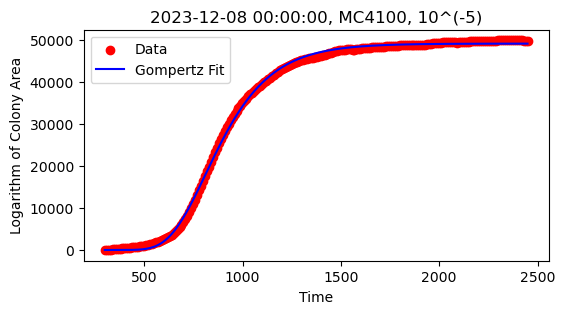

Fitted parameters [A, mu_m, lambda]: [49220.4514399     98.21552899   627.77698106], i: 134


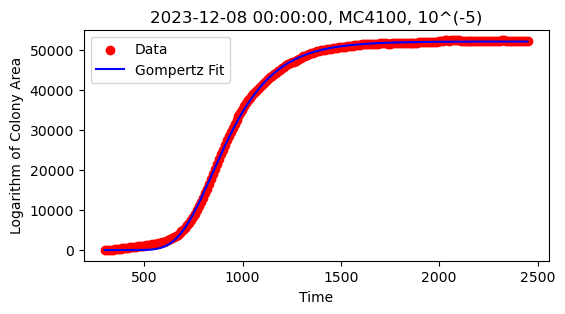

Fitted parameters [A, mu_m, lambda]: [52109.56327237   110.4049239    672.63793721], i: 135


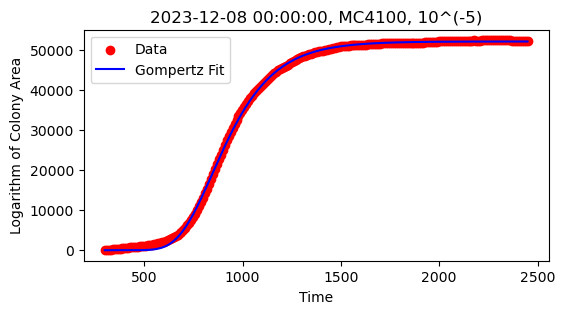

Fitted parameters [A, mu_m, lambda]: [52118.44738613   110.44317256   672.987484  ], i: 136


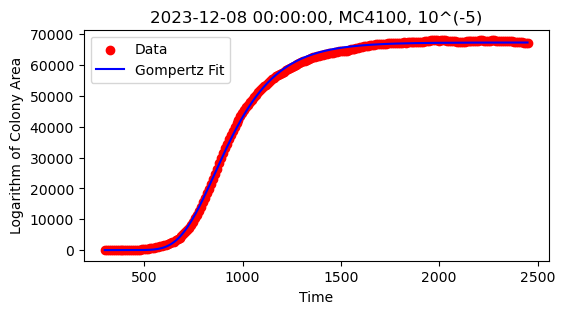

Fitted parameters [A, mu_m, lambda]: [67340.14263845   141.0215006    682.25474793], i: 137


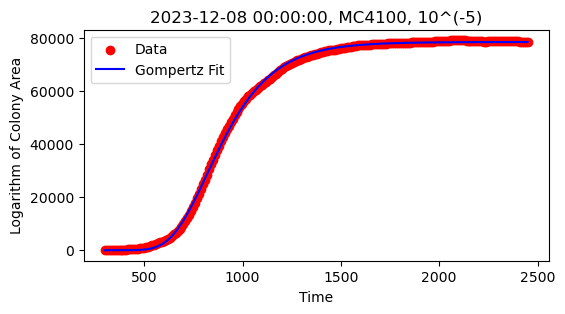

Fitted parameters [A, mu_m, lambda]: [78527.10283919   158.33384844   637.69800506], i: 138


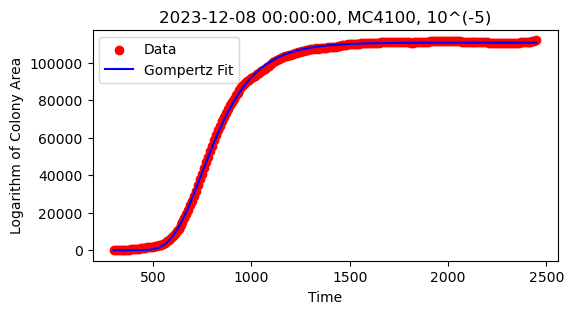

Fitted parameters [A, mu_m, lambda]: [110769.54971427    273.54901907    597.47508747], i: 139


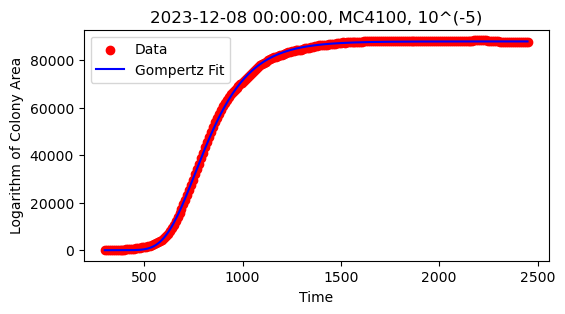

Fitted parameters [A, mu_m, lambda]: [87865.58061955   211.33553133   605.41535933], i: 140


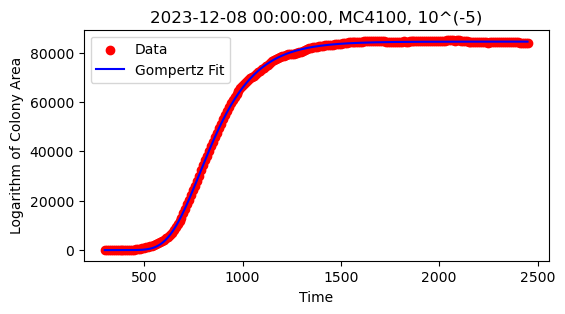

Fitted parameters [A, mu_m, lambda]: [84411.70723851   197.57620485   624.63313735], i: 141


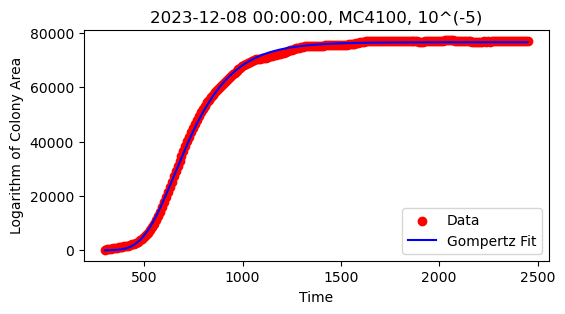

Fitted parameters [A, mu_m, lambda]: [76626.76431347   175.32282795   494.42522317], i: 142


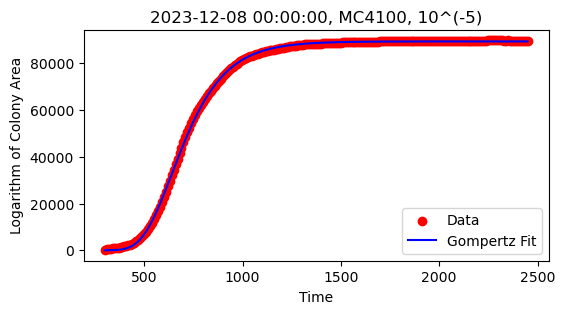

Fitted parameters [A, mu_m, lambda]: [89371.67661185   219.21506296   491.00269656], i: 143


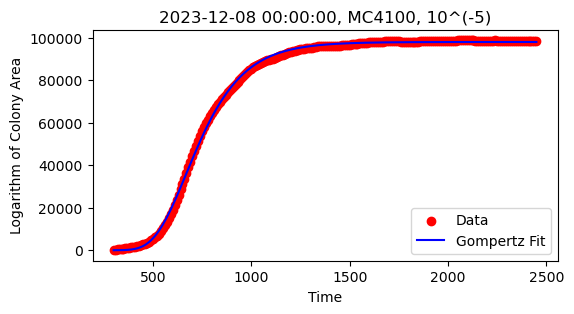

Fitted parameters [A, mu_m, lambda]: [97920.94890256   223.07422372   507.01722267], i: 144


In [145]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

for i in df.index.values:
    # Fit the model
    incub_time_s = datetime.strptime(df.loc[i,'t_im'], '%H:%M:%S') - datetime.strptime(df.loc[i,'t_incub'], '%H:%M:%S')
    incub_time_n = incub_time_s.seconds / 60
    area = extract_array(df.loc[i,'area_dyn'])
    #time_points = np.arange(1, df.loc[i, 'exp length']+1)*10 + incub_time_n
    time_points = np.arange(0, df.loc[i, 'exp length'])*10 + incub_time_n
    area_end = int(df.loc[i, 'area'])
    
    p0=[area_end, 100, incub_time_n]
    
    params, cov = curve_fit(gompertz, time_points, area, p0)
    # Plotting the data and the model to see the fit
    plt.figure(figsize=(6, 3))
    plt.scatter(time_points, area, color='red', label='Data')
    plt.plot(time_points, gompertz(time_points, *params), label='Gompertz Fit', color='blue')
    plt.title(f"{df.loc[i,'Date']}, {df.loc[i,'Strain']}, {df.loc[i,'Dilution']}")
    plt.xlabel('Time')
    plt.ylabel('Logarithm of Colony Area')
    plt.legend()
    plt.show()
    pars_dict = {'A': round(params[0],2), 'mu_m': round(params[1],2), 'lambda': round(params[2],2)}
    df.at[i, 'gomp_params'] = json.dumps(pars_dict)
    # Print the fitted parameters
    print(f"Fitted parameters [A, mu_m, lambda]: {params}, i: {i}")
df.to_excel('out.xlsx')

In [213]:
params

array([97920.94890256,   223.07422372,   507.01722267])

In [152]:
import json

### Computing t_m

In [149]:
def tm(A, mu, lambda_):
    return A/(mu * np.e) + lambda_

In [155]:
for i in df.index.values:
    pars = json.loads(df.loc[i,'gomp_params'])
    df.loc[i, 't_m'] = tm(pars['A'], pars['mu_m'], pars['lambda'])
df.to_excel('out.xlsx')

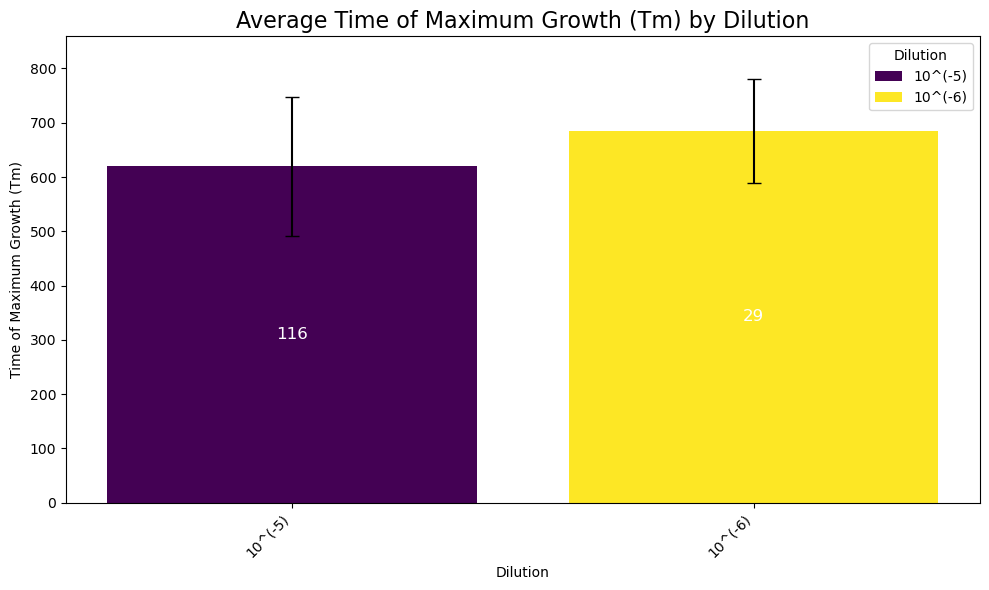

In [158]:
# Group the data by 'Dilution' and calculate mean, standard deviation, and count for 't_m'
plot_data = df.groupby('Dilution').agg({
    't_m': ['mean', 'std'],
    'Colonies': 'size'  # This counts the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Dilution', 'Tm Mean', 'Tm Std', 'Colonies Count']

# Find the global maximum for the y-axis to ensure proper scale
max_tm = plot_data['Tm Mean'] + plot_data['Tm Std']
global_max = max_tm.max()

# Create a single plot for all dilutions
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color range
tm_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

# Plot each dilution
for idx, row in plot_data.iterrows():
    ax.bar(idx, row['Tm Mean'], yerr=row['Tm Std'], capsize=5, color=tm_colors[idx], label=row['Dilution'])
    # Annotate the number of colonies inside the bar
    ax.text(idx, row['Tm Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)

ax.set_title('Average Time of Maximum Growth (Tm) by Dilution', fontsize=16)
ax.set_xlabel('Dilution')
ax.set_ylabel('Time of Maximum Growth (Tm)')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.legend(title="Dilution")

plt.tight_layout()
plt.show()

# Save the figure to a file
fig.savefig('Tm_by_Dilution_Bar.png', dpi=300)


In [137]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

From here I can use the parameters to fin the maximum growth rate, max av growth rate, etc

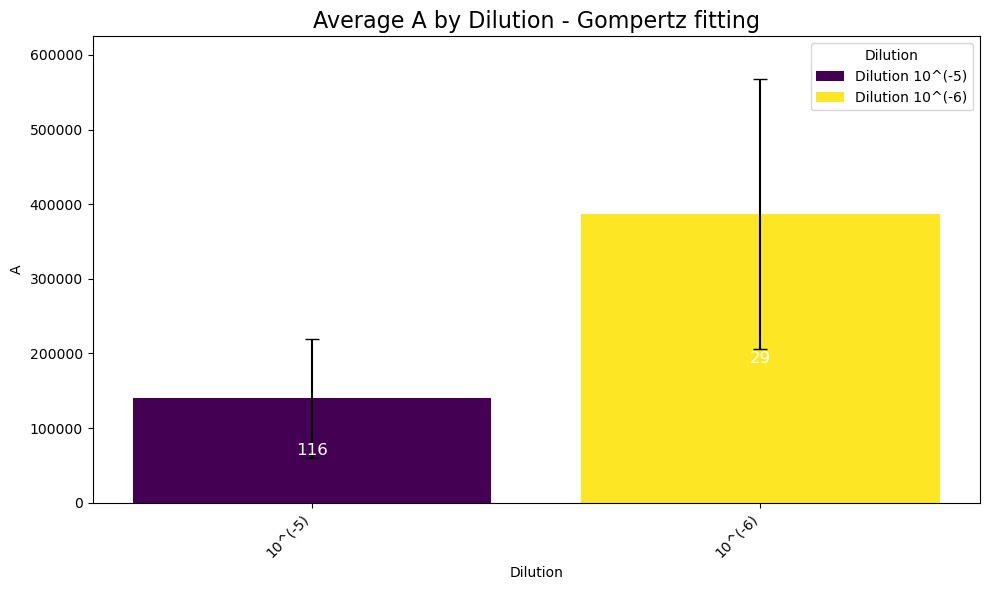

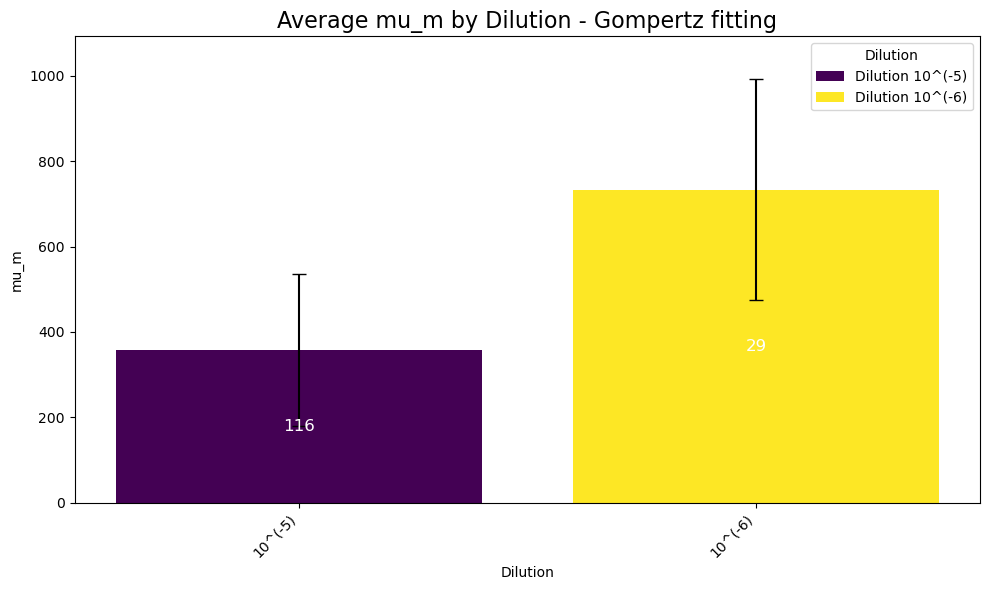

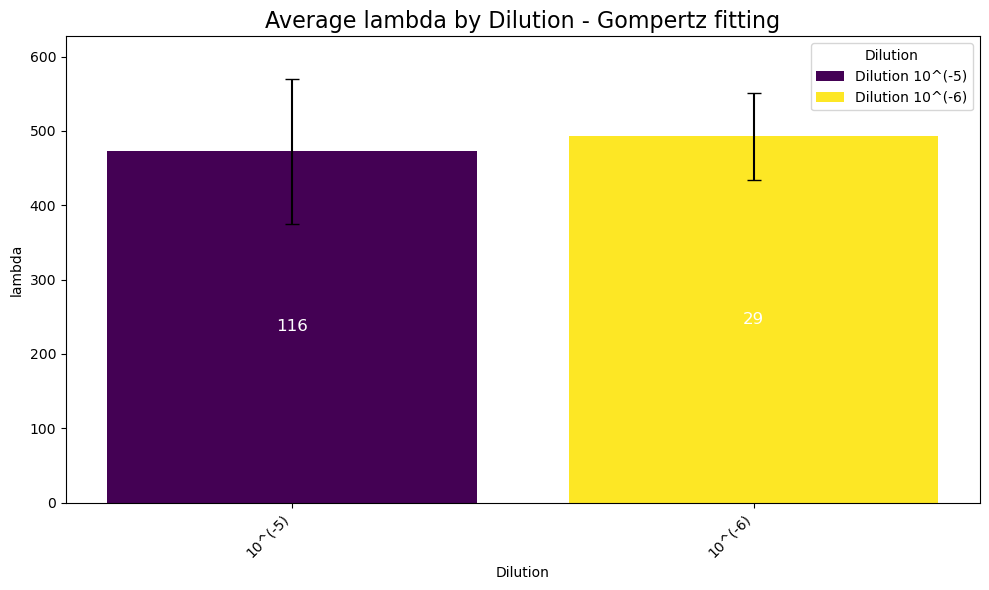

In [138]:
# Assuming 'gomp_params' is stored in JSON format with keys like 'A', 'mu_m', 'lambda'
# Convert JSON formatted string in 'gomp_params' to dictionary and extract 'lambda'
params = ['A', 'mu_m', 'lambda']
for param in params:
    df[param] = df['gomp_params'].apply(lambda x: json.loads(x)[param])
    
    # Group the data by 'Dilution' and calculate mean, standard deviation for 'lambda'
    plot_data = df.groupby('Dilution').agg({
        param: ['mean', 'std', 'size']  # 'size' to count entries, replace 'std' with 'sem' if std is not reliable
    }).reset_index()
    
    # Prepare the data for plotting
    plot_data.columns = ['Dilution', f'{param} Mean', f'{param} Std', 'Colonies Count']
    
    # Find the global maximum for the y-axis to ensure proper scale
    maxx = plot_data[f'{param} Mean'] + plot_data[f'{param} Std']
    global_max = maxx.max()
    
    # Create a single plot for all dilutions
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Generate a color range
    colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))
    
    # Plot each dilution
    for idx, row in plot_data.iterrows():
        ax.bar(idx, row[f'{param} Mean'], yerr=row[f'{param} Std'], capsize=5, color=colors[idx], label=f"Dilution {row['Dilution']}")
        # Annotate the number of colonies inside the bar
        ax.text(idx, row[f'{param} Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)
    
    ax.set_title(f'Average {param} by Dilution - Gompertz fitting', fontsize=16)
    ax.set_xlabel('Dilution')
    ax.set_ylabel(param)
    ax.set_xticks(np.arange(len(plot_data)))
    ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
    ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
    ax.legend(title="Dilution")
    
    plt.tight_layout()
    plt.show()

# Save the figure
    fig.savefig(f'{param}_Dil_Bar.png', dpi=300)  # Adjust path as needed


In [214]:
i = 9

In [167]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

In [176]:
exp = df[(df.Date == '2023-11-15') & (df.Machine == 'Tweez scope') & (df.Position == 0)]

In [223]:
t_m = exp['t_m'][i]
A = json.loads(exp['gomp_params'][i])["A"]
mu_m = json.loads(exp['gomp_params'][i])["mu_m"]
lambda_ = json.loads(exp['gomp_params'][i])["lambda"]

In [227]:
lambda_

431.25

In [212]:
tdoub = np.log(2) / (mu_m * np.e)
tdoub*10

0.002899115437650115

In [206]:
mu_m

879.56

In [216]:
incub_time_s = datetime.strptime(df.loc[i,'t_im'], '%H:%M:%S') - datetime.strptime(df.loc[i,'t_incub'], '%H:%M:%S')
incub_time_n = incub_time_s.seconds / 60
incub_time_n

275.0

In [217]:
time_points = np.arange(0, df.loc[i, 'exp length'])*10 + incub_time_n
time_points

array([ 275.,  285.,  295.,  305.,  315.,  325.,  335.,  345.,  355.,
        365.,  375.,  385.,  395.,  405.,  415.,  425.,  435.,  445.,
        455.,  465.,  475.,  485.,  495.,  505.,  515.,  525.,  535.,
        545.,  555.,  565.,  575.,  585.,  595.,  605.,  615.,  625.,
        635.,  645.,  655.,  665.,  675.,  685.,  695.,  705.,  715.,
        725.,  735.,  745.,  755.,  765.,  775.,  785.,  795.,  805.,
        815.,  825.,  835.,  845.,  855.,  865.,  875.,  885.,  895.,
        905.,  915.,  925.,  935.,  945.,  955.,  965.,  975.,  985.,
        995., 1005., 1015., 1025., 1035., 1045., 1055., 1065., 1075.,
       1085., 1095., 1105., 1115., 1125., 1135., 1145., 1155., 1165.,
       1175., 1185., 1195., 1205., 1215., 1225., 1235., 1245., 1255.,
       1265., 1275., 1285., 1295., 1305., 1315., 1325., 1335., 1345.,
       1355., 1365., 1375., 1385., 1395., 1405., 1415., 1425., 1435.,
       1445., 1455., 1465., 1475., 1485., 1495., 1505., 1515., 1525.,
       1535., 1545.,

In [234]:
def gompertz(t, A, mu_m, lambda_):
    return A * np.exp(-np.exp(mu_m * np.e / A * (lambda_ - t) + 1))

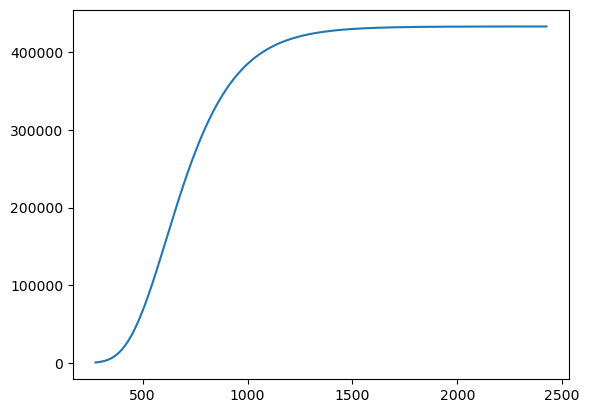

In [236]:
plt.plot(time_points, gompertz(time_points,A,mu_m, lambda_))